In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mc

import seaborn as sns

#For calculating  similarities and distances
from scipy.spatial.distance import pdist, squareform

from scipy.interpolate import interp1d

#For dimension reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import copy

from IPython.core.display import display, HTML
import math
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.path as mpath

import warnings
#Don't show warnings in the final K
warnings.filterwarnings('ignore')

Path = mpath.Path

#Load the multi-choice answers into a DataFrame
multi_df = pd.read_csv('./input/' + 'multipleChoiceResponses.csv', low_memory=False, header=[0,1])

#Store the Question ColumnName-QuestionText tuples
questions = pd.DataFrame(list(zip(multi_df.columns.get_level_values(0),multi_df.columns.get_level_values(1))))

#Drop the long descriptions, we don't need them
multi_df.columns = multi_df.columns.droplevel(1)

#Drop the personal questions
PERSONAL_QUESTIONS = ['Time from Start to Finish (seconds)','Q1','Q1_OTHER_TEXT','Q2','Q3']
multi_df.drop(PERSONAL_QUESTIONS, axis=1, inplace=True)

#Helper function to get multiple columns at once
def get_cols_with_prefix(df, prefix):
    return [col for col in df.columns.values if col.startswith(prefix)]

#Let's give these frequently used columns aliases:
C_TITLE = 'Q6'
#TODO: add Q6_original, Q24_Buckets

#Drop those who didn't complete their title information
multi_df.dropna(subset=[C_TITLE], inplace=True)

#These should be transformed to 1/0
BINARY_COLUMNS = (
    get_cols_with_prefix(multi_df, "Q11_Part")+
    get_cols_with_prefix(multi_df, "Q13_Part")+
    get_cols_with_prefix(multi_df, "Q14_Part")+
    get_cols_with_prefix(multi_df, "Q15_Part")+
    get_cols_with_prefix(multi_df, "Q16_Part")+
    get_cols_with_prefix(multi_df, "Q19_Part")+
    get_cols_with_prefix(multi_df, "Q21_Part")+
    get_cols_with_prefix(multi_df, "Q27_Part")+
    get_cols_with_prefix(multi_df, "Q28_Part")+
    get_cols_with_prefix(multi_df, "Q29_Part")+
    get_cols_with_prefix(multi_df, "Q30_Part")
)

# Convert the Binary Columns
multi_df[BINARY_COLUMNS] = multi_df[BINARY_COLUMNS].notnull().astype(int)

#These should be imputed when not available, then scaled
#WARNING! after imputation the values won't add up to 100%!
VALUE_COLUMNS = ['Q34_Part_1','Q34_Part_2','Q34_Part_3','Q34_Part_4','Q34_Part_5','Q34_Part_6']

#Remove missing Value columns
multi_df.dropna(subset=VALUE_COLUMNS, inplace=True)
#Convert percent values to 0-1 range
multi_df[VALUE_COLUMNS]=multi_df[VALUE_COLUMNS]/100

#Replace Q12 - Primary tool values - Convert to shorter values
primary_tool_map = {
    'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)':'Cloud',
    'Basic statistical software (Microsoft Excel, Google Sheets, etc.)':'BasicStat',
    'Local or hosted development environments (RStudio, JupyterLab, etc.)':'DevEnv',
    'Advanced statistical software (SPSS, SAS, etc.)':'AdvancedStat',
    'Other':'Other',
    'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)':'BI',
    'nan':np.nan
}
multi_df['Q12_MULTIPLE_CHOICE'] = multi_df['Q12_MULTIPLE_CHOICE'].apply(lambda tool: primary_tool_map.get(str(tool), tool))
dummies = pd.get_dummies(multi_df["Q12_MULTIPLE_CHOICE"],prefix="Q12_MC_Part")
multi_df = pd.concat([multi_df, dummies], axis=1)

#Replace Q17 - Most used Programming Language - Create dummy columns
dummies = pd.get_dummies(multi_df["Q17"],prefix="Q17_Part")
multi_df = pd.concat([multi_df, dummies], axis=1)

#Replace Q20 - Most used ML tool - Create dummy columns
dummies = pd.get_dummies(multi_df["Q20"],prefix="Q20_Part")
multi_df = pd.concat([multi_df, dummies], axis=1)

#Replace Q22 - DataViz tools - Create dummy columns
dummies = pd.get_dummies(multi_df["Q22"],prefix="Q22_Part")
multi_df = pd.concat([multi_df, dummies], axis=1)

#Replace Q23 - Time spent coding - Convert to 0-1 range
time_spent_map = {
    '0% of my time': 0,
    '1% to 25% of my time':1,
    '25% to 49% of my time':2,
    '50% to 74% of my time': 3,
    '75% to 99% of my time':4,
    '100% of my time': 5,
    'nan':0
}
multi_df['Q23'] = multi_df['Q23'].apply(lambda tool: time_spent_map.get(str(tool), tool))/5

#Replace Q26 - Do you consider yourself a Data Scientist? - Convert to 0-1 range
self_ds_map = {
    'Definitely yes':4,
    'Probably yes':3,
    'Maybe':2,
    'Probably not':1,
    'Definitely not':0,
    'nan':np.nan
}
multi_df['Q26'] = multi_df['Q26'].apply(lambda tool: self_ds_map.get(str(tool), tool))/4

#Replace Q48 - Black box
black_box_map = {
'I am confident that I can explain the outputs of most if not all ML models':4,
'I am confident that I can understand and explain the outputs of many but not all ML models':3,
'I do not know; I have no opinion on the matter':2,
'I view ML models as "black boxes" but I am confident that experts are able to explain model outputs':1,
'Yes, most ML models are "black boxes"':0
}
multi_df['Q48'] = multi_df['Q48'].apply(lambda tool: black_box_map.get(str(tool), tool))/4

#Merge some role groups
roles_map = {
'Research Assistant':'Research Scientist',
'Principal Investigator':'Research Scientist',

'DBA/Database Engineer':'Data Engineer',

'Marketing Analyst':'Data Analyst',
'Data Journalist':'Data Analyst',
'Business Analyst':'Data Analyst',
'Salesperson':'Data Analyst',

'Student':np.nan,
'Not employed':np.nan,
'Consultant':"Other",
'Other':np.nan,
'Product/Project Manager':np.nan,
'Chief Officer':np.nan,
'Manager':np.nan,
'Developer Advocate': np.nan,
}

#Replace values in the map, keep unmapped values unchanged
multi_df['Q6_original']=multi_df['Q6']
multi_df['Q6'] = multi_df['Q6'].apply(lambda role: roles_map.get(role, role))

multi_df['Q8'].unique()
experience_map = {
    '0-1':'0',
    '1-2':'1',
    '2-3':'2',
    '3-4':'3',
    '4-5':'4',
    '5-10':'5',
    '10-15':'10',
    '15-20':'15',
    '20-25':'20',
    '25-30':'25',
    '30 +':'30',
    'nan':np.nan
}
multi_df['Q8_Buckets'] = multi_df['Q8'].apply(lambda tool: experience_map.get(str(tool), tool))
multi_df['Q8_Buckets'].unique()
multi_df['Q8_Buckets'] = multi_df['Q8_Buckets'].astype(float)

multi_df['Q24'].unique()
code_experience_map = {
    'I have never written code but I want to learn':'1',
    '< 1 year':'1',
    '1-2 years':'2',
    '3-5 years':'3',
    '5-10 years':'4',
    '10-20 years':'5',
    '20-30 years':'5',
    '30-40 years':'5',
    '40+ years':'5',
    'I have never written code and I do not want to learn':np.nan,
    'nan':np.nan
}

Q24_bucket_labels = {
"1":"Intern",
"2":"Junior",
"3":"Middle",
"4":"Senior",
"5":"Veteran"
}
multi_df['Q24_Buckets'] = multi_df['Q24'].apply(lambda tool: code_experience_map.get(str(tool), tool))
multi_df['Q24_Buckets'].unique()
multi_df['Q24_Buckets'] = multi_df['Q24_Buckets'].astype(float)

In [2]:
arrow_svg = """
<svg version="1.1" id="Arrow_down" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
 viewBox="0 0 20 20" enable-background="new 0 0 20 20" xml:space="preserve">
<path d="M10,17.5L3.5,11H7V3h6v8h3.5L10,17.5z"/>
"""

html = """
<style>
    .mv-title-container{
        display:flex;
        flex-direction:column;
        align-items:center;
        justify-content:center;
        height:auto;
    }
    .mv-title-container h1{
        white-space:pre-wrap;
        text-align:center;
    }
    
    .mv-title-keyword{
        color:#5DADE2;
    }
    .mv-title-arrow{
        color: #5DADE2;
    }
    
    .mv-title-arrow svg{
        fill:#5DADE2;
        stroke:none;
        width:100px;
    }
</style>

<div class="mv-title-container">
    <h1><span>If you have completed the Kaggle ML & DS Survey 2018, </span>
<span class="mv-title-keyword">one of these dots is You.</span></h1>
        

    <div class="mv-title-arrow">"""+arrow_svg+"""</div>
</div>
"""

display(HTML(html))

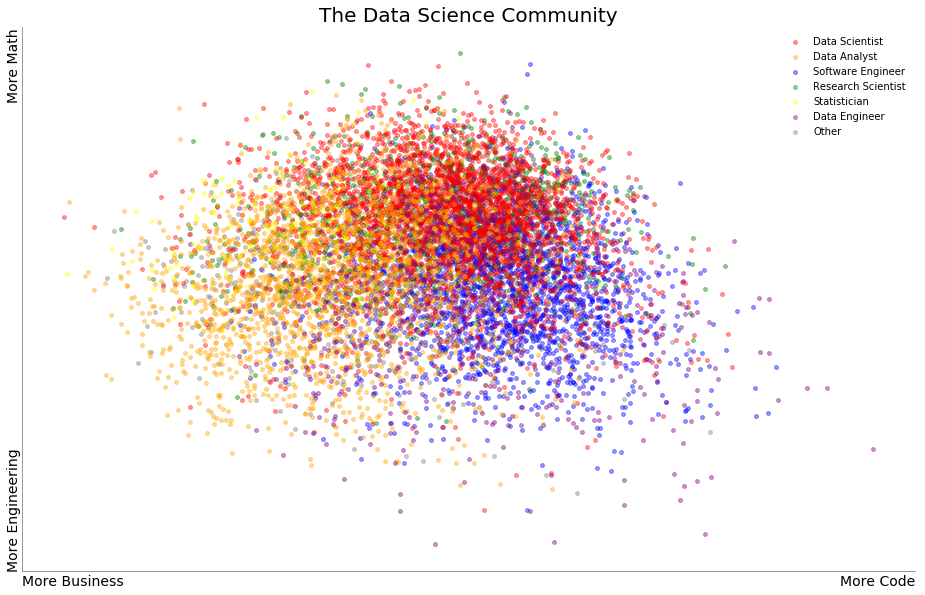

In [3]:
#Give each of the original titles a color
color_map_original = {
    'Consultant':'black', 
    'Other':'black',  
    'Data Journalist':'black', 
    'Not employed':'black', 
    
    'Student':'lightgreen', 
    
    'Research Assistant':'green', 
    'Research Scientist':'green', 
    'Principal Investigator':'green', 
    
    'Data Analyst':'orange', 
    'Business Analyst':'orange', 
    'Marketing Analyst':'orange', 
    'Salesperson':'orange', 
    
    'Data Engineer':'purple',
    'DBA/Database Engineer':'purple',
    
    'Developer Advocate':'blue',  
    'Software Engineer':'blue', 
    
    'Data Scientist':'red', 
    
    'Chief Officer':'lightgray', 
    'Manager':'lightgray', 
    'Product/Project Manager':'lightgray', 
    
    'Statistician':'yellow', 
    
}

#Give each of the new titles a color
colors = [
    'red', #Data Scientist
    'green',  #Data Analyst
    'blue', #Software Engineer
    'orange', #Research Scientist
    'yellow',#Statistician
    'purple', #Data Engineer
    'lemonchiffon',  #Other 
]


color_maps = {
    'red':'Reds', #Data Scientist
    'green':'Greens',  #Data Analyst
    'blue':'Blues', #Software Engineer
    'orange':'Oranges', #Research Scientist
    'purple':'Purples', #Data Engineer
     'gray':'Greys',#Statistician,
    'yellow':'Oranges' #Other
}

#Keep only columns which are potentially good predictors of the role
relevant_columns_for_roles_reduction = (
    get_cols_with_prefix(multi_df, "Q11_Part")+ #primary activities
    get_cols_with_prefix(multi_df, "Q16_Part")+ #programming languages used
    get_cols_with_prefix(multi_df, "Q34_Part")+ #time spent with activities (smaller than 1)
    get_cols_with_prefix(multi_df, "Q12_MC_Part")+ #primary tool
    get_cols_with_prefix(multi_df, "Q28_Part")+ #machine learning products
    get_cols_with_prefix(multi_df, "Q30_Part")+ #big data products
    get_cols_with_prefix(multi_df, "Q17_Part")+ #primary language
    ["Q23" ] #time spent coding (smaller than 1)
)
roles_df = multi_df[relevant_columns_for_roles_reduction].copy()

#Exclude the null values when computing the LDA
set_roles_titles = multi_df[C_TITLE].dropna()
set_roles_df = roles_df[multi_df[C_TITLE].notnull()]

centroids = set_roles_df.groupby(set_roles_titles).mean()

set_roles_original_titles = multi_df["Q6_original"].dropna()
set_roles_original_df = roles_df[multi_df["Q6_original"].notnull()]
centroids_original = set_roles_original_df.groupby(set_roles_original_titles).mean()

lda = LinearDiscriminantAnalysis(n_components=2, priors = set_roles_titles.value_counts(normalize=True).values)

drA = lda.fit_transform(set_roles_df, set_roles_titles)

principalDf = pd.DataFrame(data = drA
             , columns = ['principal component 1', 'principal component 2'], index=set_roles_df.index)
finalDf = pd.concat([principalDf, set_roles_titles], axis = 1)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel(PRINCIPAL_COMP_1_NAME, fontsize = 15)
#ax.set_ylabel(PRINCIPAL_COMP_2_NAME, fontsize = 15)
ax.set_title('The Data Science Community', fontsize = 20)

targets_colors = [
    ("Other","gray"),
    ("Research Scientist","green"),
    ("Software Engineer","blue"),
    ('Data Scientist',"red"),
    ('Data Analyst', "orange"),
    ("Data Engineer","purple"),
    ("Statistician","yellow")
]

target_order= {
    'Data Scientist':0, 
    'Data Analyst':1, 
    'Software Engineer':2,
    'Research Scientist':3, 
    'Statistician':4,
    'Data Engineer':5, 
    "Other":6
}

for target, color in targets_colors:
    indicesToKeep = finalDf[C_TITLE] == target
    a = 0.4
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               ,alpha=a
               , s = 15)
    
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip([target for target, color in  targets_colors], handles), key=lambda t: target_order[t[0]]))
legend = ax.legend(handles, labels)

#legend = ax.legend(targets)
legend.get_frame().set_edgecolor("white")

ax.set_xticks([])
ax.set_yticks([])



min_x, max_x = ax.get_xlim()
min_y, max_y = ax.get_ylim()

x_offset = 0.01
y_offset = 0.05
ax.text(min_x-x_offset, max_y,"More Math", ha="right", va="top", rotation=90, fontsize=14)
ax.text(min_x-x_offset, min_y,"More Engineering", ha="right", va="bottom", rotation=90, fontsize=14)

ax.text(min_x, min_y-y_offset,"More Business", ha="left", va="top", fontsize=14, color="black")
ax.text(max_x, min_y-y_offset,"More Code", ha="right", va="top", fontsize=14, color="black")
plt.setp(ax.spines.values(), color="gray")

# Hide the right and left spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines["top"].set_color("gray")
ax.spines["right"].set_color("gray")

### The Kaggle Data Science Survey


If you missed it, don't worry, you can join us next year. With over 20,000 respondents, The **Kaggle ML & DS 2018** is one of, if not the most important and extensive surveys ever conducted about  the state of the Data Science community. The data set contains answers to over 50 questions, many of them multi-choice or even free text, so there's a huge playground for data lovers to explore.


# Let's get employed!

The theme of this study is **employability**, so most of my exploration will focus on a - rather large - subset of the community: those employed and currently active in one of the major roles of the Data Science field.

>  **employability**, noun
>
> Being in possession of skills which are in high demand on the job market.
> 
> <sub><cite>(my personal definition)</cite></sub>


In the first part of this kernel I will use a selection of the survey data to answer questions like:

 * **Which are the most important roles in the Data Science field? **

* **What are the individual characteristics of these roles? **

* **What sets them apart, makes them different? **

* **Which tech skills are most required for each of them? **

I think the answers to these questions are especially relevant to students, to the unemployed and to anyone planning a career transition or simply ways to improve themselves. Hopefully the reader of this kernel doesn't share the following opinion:

> "I'm a student, don't ask these questions please"
>
> <sub><cite>Responder #27 in Free Form Responses</cite></sub>


In  the second part I will focus on technology stacks specific to each role, comparing the supply and demand for them on the job market and identifying the most useful skills to possess.





# Choosing the right role

If you are a student or just recently started your career and are still unsure about the technology skills to target or if you are an experienced data scientist looking for ways to improve your chances on the job market, the first step is to identify all possibilities and explore the differences between them. The roles I personally consider most relevant are:

* **Data Scientist**
* **Data Analyst**
* **Software Engineer**
* **Research Scientist**
* **Data Engineer**
* **Statistician**

#### Mapping the community

I cleaned up the data by imputing missing values, transforming to dummy variables and normalizing numerical values. I then used [LDA](https://sebastianraschka.com/Articles/2014_python_lda.html) to perform supervised [dimensionality reduction](https://idyll.pub/post/dimensionality-reduction-293e465c2a3443e8941b016d/) and map the resulting feature vectors to a 2 dimensional space while maximing the separation of the clusters.  The feature set I used for LDA is based on questions which I felt are the best predictors of a person's daily activity at work. 

The interpretation of the resulting principal components and naming of the axes is highly subjective because it is the weighted combination of multiple features and can be too complex to describe in simple words. Based on the resulting positions of the various groups I like to think of **PC1(horizontal)** as a **Business (left) vs.  Code (right)** axis and of **PC2 (vertical)** as an **Engineering (bottom) vs. Research (top)** axis.

### Where are these role situated in relation to each-other?

As you probably noticed on the first image, the clusters are clearly overlapping, the definitions of these roles are extremely fuzzy. For example the **Data Analyst** and **Business Analyst** roles share most of the same characteristics with slight differences in the application of the conclusions resulting from the analysis.  To avoid cluttering / having too many categories, in some of the charts I merged some of the less-represented groups:
* (Student, Not employed, Consultant, Other, Developer Advocate) → drop
* (Project Manager, Chief Officer) → Manager
* (Research Assistant, Principal Investigator) → Research Scientist
* (Data Journalist, Business Analyst) → Business Analyst
* (Database Engineer) → Data Engineer

Despite the overlaps, the positions of the cluster centroids reveal some interesting patterns. The size of the bubbles represent the size of the group.


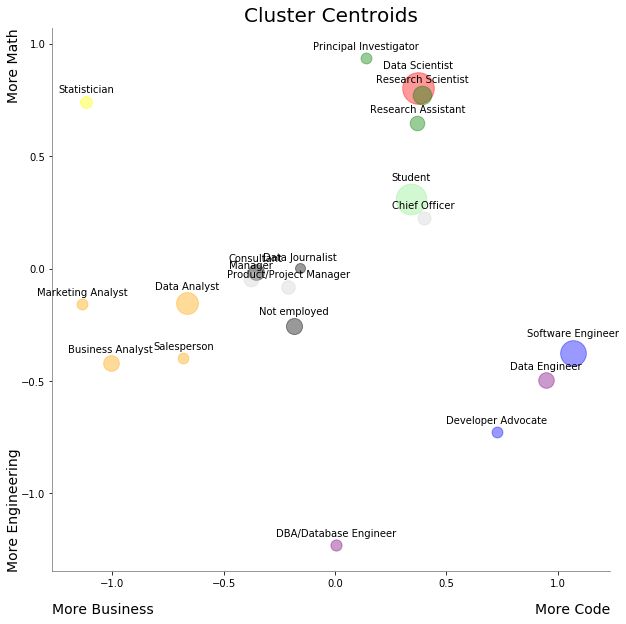

In [4]:
sizes = multi_df.groupby("Q6_original").size()
min_size = sizes.min()
max_size = sizes.max()


PRINCIPAL_COMP_1_NAME = "Business ↔ Code"
PRINCIPAL_COMP_2_NAME = "Engineering ↔ Math"


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel(PRINCIPAL_COMP_1_NAME, fontsize = 15)
#ax.set_ylabel(PRINCIPAL_COMP_2_NAME, fontsize = 15)
ax.set_title('Cluster Centroids', fontsize = 20)
targets = np.setdiff1d(multi_df["Q6_original"].dropna().unique(),["Other"])
dot_size_min = 100
dot_size_max = 1000

for target in targets:
    vector = pd.DataFrame(centroids_original.loc[target]).T
    size_p = (sizes[target] - min_size) /(max_size - min_size)
    size = dot_size_min + size_p * (dot_size_max - dot_size_min)
    coords = lda.transform(vector)[0]
    x = [coords[0]]
    y =  [coords[1]]
    radius = (size / 3.14) ** 0.5
    ax.scatter(x,y, c = color_map_original[target],alpha=0.4, s = size)
    ax.annotate(target, 
                xy = (x[0], y[0]), 
                xytext = (0,2 + radius), 
                textcoords='offset points', 
                horizontalalignment="center")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

min_x, max_x = ax.get_xlim()
min_y, max_y = ax.get_ylim()

x_offset = 0.14
y_offset = 0.14
ax.text(min_x-x_offset, max_y,"More Math", ha="right", va="top", rotation=90, fontsize=14)
ax.text(min_x-x_offset, min_y,"More Engineering", ha="right", va="bottom", rotation=90, fontsize=14)

ax.text(min_x, min_y-y_offset,"More Business", ha="left", va="top", fontsize=14, color="black")
ax.text(max_x, min_y-y_offset,"More Code", ha="right", va="top", fontsize=14, color="black")
plt.setp(ax.spines.values(), color="gray")

# Hide the right and left spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines["top"].set_color("gray")
#ax.spines["right"].set_color("gray")

#### Observations:
* The marketing & business roles form a cluster group in the center left area of the chart, not far from the closely related **Management** clusters, which use the reports and analyses provided by the **Data Analysts** to making data driven business decisions.
* The academical roles, namely **Principal Investigator**, **Research Investigator** and **Research Scientist** form a tight cluster group in the top center part of the chart. They are the most similar to the **Data Scientist** role from a technical point of view.
* The **Student** cluster lies close to the other academic roles, with an observable offset towards the more practical, engineering-related clusters.
* **Database Engineer** lies further than expected from the **Data Engineer** cluster. The reason might be that these roles consist of a lot of querying, report generation and data maintenance which is more closely related to what the Business cluster group does. 
* **Student**, and **Chief Officer** and **Consultant** are the real Jack-of-All-Trades roles in the **Data Science** community. I imagine these **Chief Officers** as former **Data Scientist** now leading a **AI** or **Big Data**-driven startups.

### What are they doing each day?


Let's explore these roles by work methodology. For the first 5 categories I calculated the percent of people considering that particular acitivity important. 

> Q11 - Which activities make up an important of your role at work?

For the importance of code writing the answers were given as percents, so I used them directly.

>Q23: Approximately what percent of your time at work or school is spent actively coding?

The colored bars represent the deviation from the mean measured in percent points. The little dots next to the boxes indicate that the value is the maximum (blue) or minimum(red) in the row in question.

#### Main activities


In [5]:
relevant_columns_for_individual_roles=(
    get_cols_with_prefix(multi_df, "Q11_Part")+ #primary activities
    get_cols_with_prefix(multi_df, "Q12_MC_Part")+ #primary tool
    ["Q23" ]+ #time spent coding (smaller than 1)
    ["Q26" ]+ #are you a Data Scientist?
    get_cols_with_prefix(multi_df, "Q34_Part")+ #time spent with activities (smaller than 1)
    get_cols_with_prefix(multi_df, "Q17_Part")+ #primary language
    ["Q48"]  
)

positive_color="#117bd7"
negative_color="orange"

# Drop the Other values from the Dataframe
multi_df.loc[(multi_df[C_TITLE]=="Other"),C_TITLE]=np.nan
individual_roles_df = multi_df[relevant_columns_for_individual_roles].copy()
set_roles_titles = multi_df[C_TITLE].dropna()
set_individual_roles_df = individual_roles_df[multi_df[C_TITLE].notnull()]
global_mean = set_individual_roles_df.mean()
individual_centroids = set_individual_roles_df.groupby(set_roles_titles).mean()

relevant_q11_columns = [
    'Q11_Part_1',
    'Q11_Part_2',
    'Q11_Part_3',
    'Q11_Part_4',
    'Q11_Part_5',
    "Q23"
]
q11_column_labels = ["Analyze Data","Build ML Service","Build Infrastructure","Explore Applying ML","Research ML","Write Code"]
q11_centroids = individual_centroids[relevant_q11_columns]
q11_centroids.columns=q11_column_labels
q11_global_mean = global_mean[relevant_q11_columns]
q11_global_mean.index = q11_column_labels
q11_data = (q11_centroids - q11_global_mean).T
q11_data_ranks = q11_data.rank(axis=1)

def visualize_role_differences(data, ranks, global_mean, global_x_max):
    row_height = 1

    # plot it
    f, axs  = plt.subplots(7,8, gridspec_kw = {'width_ratios':[0.8]+[1]*7,'hspace':0,'wspace':0.35}, figsize=(16,row_height * len(data)))



    #rows
    for i in range(0,6):

        # Row Labels
        ax = axs[i,0]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

        # Hide the right and left spines
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
            spine.set_edgecolor('lightgray')

        ax.text(1.5, 0.5,data.index[i], ha="right", va="center")
        ax.set_xlim(left=-1, right=1)
        ax.set_ylim(bottom=0, top=1)

        # Mean charts
        ax = axs[i,1]

        if (i == 0):
            ax.set_title("Overall Mean")

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

        # Hide the right and left spines
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        for spine in ax.spines.values():
                spine.set_edgecolor('lightgray')
        value = global_mean[i]

        rect = patches.Rectangle((0,0.1),value,0.8,linewidth=1,edgecolor='black',facecolor="gray",alpha=0.5)
        ax.add_patch(rect)
        pct = int(round(value * 100))
        ax.text(value + 0.05*global_x_max, 0.5,"{}%".format(pct), ha="left", va="center")
        ax.set_xlim(xmin=0, xmax=global_x_max)
        ax.set_ylim(ymin=0, ymax=1)

        #columns
        for j in range(2,8):
            #[row,column]
            ax = axs[i,j]
            if (i == 0):
                ax.set_title(data.columns[j-2])
            # Hide the right and left spines
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)

            value = data.values[i,j-2]
            rank = ranks.values[i,j-2]
            color = positive_color if value > 0 else negative_color
            offset = +1 if value > 0 else -1
            sign = "+" if value > 0 else ""
            rect = patches.Rectangle((0,0.1),value,0.8,linewidth=1,edgecolor='black',facecolor=color,alpha=0.7)
            ax.add_patch(rect)
            if (rank == 1 or rank == 6):
                circle = patches.Ellipse((offset * -0.1 * global_x_max,0.5),
                                         width=0.05*global_x_max,
                                         height=0.1,
                                         linewidth=1,
                                         edgecolor='black',
                                         facecolor=color,
                                         alpha=0.7
                                         )
                ax.add_patch(circle)

            pct = int(round(value * 100))
            alignment = "left" if value > 0 else "right"
            ax.text(value + offset * 0.01, 0.5,"{}{}%".format(sign, pct), ha=alignment, va="center")
            ax.plot([0,0], [1,0],linestyle="--",linewidth=1,color="gray")
            ax.set_xlim(xmin=-0.5*global_x_max, xmax=0.5*global_x_max)
            ax.set_ylim(ymin=0, ymax=1)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor('lightgray')

        ax = axs[6,0]
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        ax = axs[6,1]
        ax.grid(False)
        ax.set_xlim(left=0, right=1)
        ax.set_ylim(bottom=0, top=1)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(top=True,
                           bottom=False,
                           right=False,
                           left=False,
                           labeltop=False,
                           labelbottom=False,
                           labelright=False,
                           labelleft=False,
                           colors="gray",
                           direction="in")
        for spine in ax.spines.values():
                spine.set_edgecolor('gray')
        ax.text(0, 0.6,"0%", ha="center", va="bottom", fontsize=8, fontweight=100, color="gray")
        ax.text(0.5, 0.6,"{}%".format(int(50*global_x_max)), ha="center", va="bottom", fontsize=8, fontweight=100, color="gray")
        ax.text(1, 0.6,"{}%".format(int(100*global_x_max)), ha="center", va="bottom", fontsize=8, fontweight=100, color="gray")

        #columns
        for j in range(2,8):
            ax = axs[6,j]
            ax.set_xlim(left=-0.5*global_x_max, right=0.5*global_x_max)
            ax.set_ylim(bottom=0, top=1)
            ax.tick_params(top=True,
                           bottom=False,
                           right=False,
                           left=False,
                           labeltop=False,
                           labelbottom=False,
                           labelright=False,
                           labelleft=False,
                           colors="gray",
                           direction="in")
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')

            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            
            ax.set_xticks([-0.5*global_x_max,0,0.5*global_x_max])
            ax.set_yticks([])
        
            ax.text(-0.5*global_x_max, 0.6,"-{}%".format(int(50*global_x_max)), ha="center", va="bottom", fontsize=8, fontweight=0, color="gray")
            ax.text(0, 0.6,"0%", ha="center", va="bottom", fontsize=8, fontweight=0, color="gray")
            ax.text(0.5*global_x_max, 0.6,"+{}%".format(int(50*global_x_max)), ha="center", va="bottom",fontsize=8, fontweight=0, color="gray")

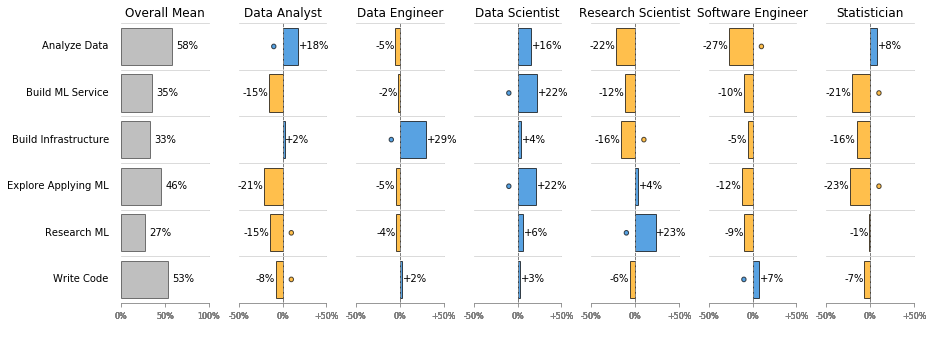

In [6]:
visualize_role_differences(q11_data,q11_data_ranks, q11_global_mean, 1)

#### Observations
* These two questions perfectly capture the essence of the roles.  Most roles have a single strong-point, **Data Scientist** being the exception. They give above-average importance to each of the activities and are clear leaders in both building and exploring ML solutions. This supports the preconception that Data Scientist are expected to be well versed in multiple domains.

#### Data pipeline

Now let's see how much of their time each step of the data pipeline is taking. 

> Q34 - During a data science project, approximately what proportion of your time is devoted to the following activities?

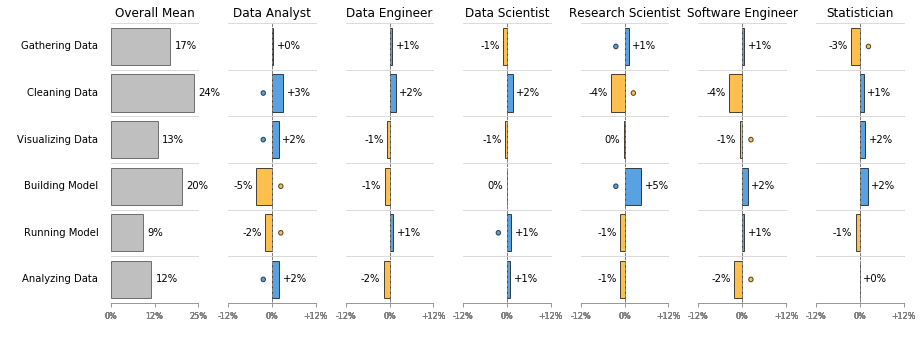

In [7]:
relevant_q34_columns = [
    'Q34_Part_1',
    'Q34_Part_2',
    'Q34_Part_3',
    'Q34_Part_4',
    'Q34_Part_5',
    'Q34_Part_6'
]
q34_column_labels = [
    "Gathering Data",
    "Cleaning Data",
    "Visualizing Data",
    "Building Model",
    "Running Model",
    "Analyzing Data"]
q34_centroids = individual_centroids[relevant_q34_columns]
q34_centroids.columns=q34_column_labels
q34_global_mean = global_mean[relevant_q34_columns]
q34_global_mean.index = q34_column_labels

q34_data = (q34_centroids - q34_global_mean).T

q34_data_ranks = q34_data.rank(axis=1)

visualize_role_differences(q34_data,q34_data_ranks, q34_global_mean, 0.25)

#### Observations:
* The cleaning of the data is the most important part of the data pipeline. **Research Scientist ** and **Software Engineer** are the lucky ones who get their data served on a silver plate. They are also the ones who spend the least time analysing it.

#### Tool usage
What kind of tools and software do they use?
> Q12 - What is the primary tool that you use to analyze data?

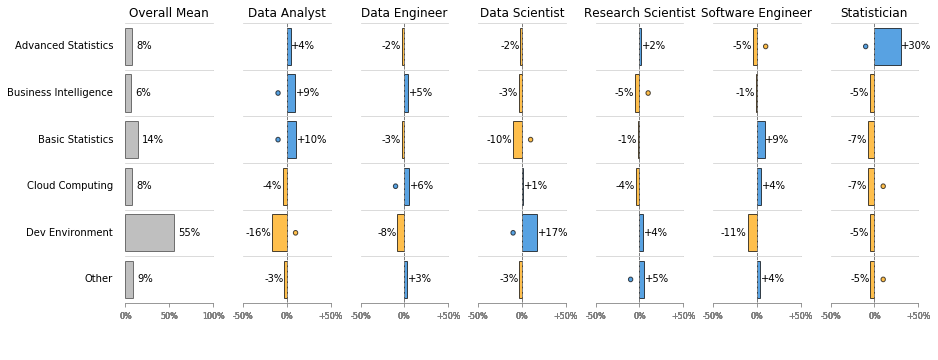

In [8]:
relevant_q12_columns = [
    'Q12_MC_Part_AdvancedStat',
    'Q12_MC_Part_BI',
    'Q12_MC_Part_BasicStat',      
    'Q12_MC_Part_Cloud',
    'Q12_MC_Part_DevEnv',
    'Q12_MC_Part_Other'
]

q12_column_labels = [
    "Advanced Statistics",
    "Business Intelligence",
    "Basic Statistics",
    "Cloud Computing",
    "Dev Environment",
    "Other"
]

q12_centroids = individual_centroids[relevant_q12_columns]
q12_centroids.columns=q12_column_labels

q12_global_mean = global_mean[relevant_q12_columns]
q12_global_mean.index = q12_column_labels

q12_data = (q12_centroids - q12_global_mean).T

q12_data_ranks = q12_data.rank(axis=1)

visualize_role_differences(q12_data,q12_data_ranks, q12_global_mean, 1)

#### Observations
* **Statisticians** are leaders in advanced statistics by a far margin.
* **Research Scientists** are leaders in usage of other types of Software Packages, these are probably the domain-specific software they use for bioinformatics, physics, math.

In [9]:
def negative_count(g):
    pcts = g.value_counts(normalize=True, sort = False).sort_index()
    return pcts.iloc[0]+pcts.iloc[1]+pcts.iloc[2]/2
    
def positive_count(g):
    pcts = g.value_counts(normalize=True,sort = False).sort_index()
    return pcts.iloc[3]+pcts.iloc[4]+pcts.iloc[2]/2

q26_value_labels = [
    'Definitely not',
    'Probably not',
    'Maybe',
    'Probably yes',
    'Definitely yes'    
]
q26_global_mean = set_individual_roles_df["Q26"].value_counts(normalize=True).sort_index()
q26_mean_by_role = set_individual_roles_df.groupby(set_roles_titles)["Q26"].value_counts(normalize=True).sort_index().unstack()
q26_mean_by_role.columns = q26_value_labels
q26_sentiment_count = set_individual_roles_df.groupby(set_roles_titles)["Q26"].agg([positive_count, negative_count])
q26_data = pd.concat([q26_mean_by_role,q26_sentiment_count], axis=1).sort_values(by=["negative_count"])
q26_data.name = "Do you consider yourself to be a data scientist?"

q48_value_labels = [
    'Most models are black boxes',
    'I do not know / No opinion',
    'Experts can explain them',
    'I can explain many',
    'I can explain most'
]
q48_global_mean = set_individual_roles_df["Q48"].value_counts(normalize=True).sort_index()
q48_mean_by_role = set_individual_roles_df.groupby(set_roles_titles)["Q48"].value_counts(normalize=True).sort_index().unstack()
q48_mean_by_role.columns = q48_value_labels
q48_sentiment_count = set_individual_roles_df.groupby(set_roles_titles)["Q48"].agg([positive_count, negative_count])
q48_data = pd.concat([q48_mean_by_role,q48_sentiment_count], axis=1).sort_values(by=["negative_count"])
q48_data.name = "Do you consider Machine Learning models to be black boxes?"


sentiment_color_map=["#363299","#117bd7","#25b4a7","#86bf76","#f9d229"]


def visualize_opinions(data):
    row_height = 0.5

    norm = mc.Normalize(vmin=-data.iloc[0]["negative_count"], vmax=data.iloc[0]["positive_count"], clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)




    # plot it
    f, axs  = plt.subplots(6,3, 
                           gridspec_kw = {'width_ratios':[1,7,2],'hspace':0,'wspace':0.35}, 
                           figsize=(15,row_height * len(data)))

    ax = axs[0,1]
    ax.set_title(data.name, loc="center")

    #rows
    for i in range(6):
        # Row labels
        ax = axs[i,0]

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.text(1, 0.5,data.index[i], ha="right", va="center", fontsize=14)
        ax.set_xlim(xmin=-1, xmax=1)
        ax.set_ylim(ymin=0, ymax=1)

        #Charts
        ax = axs[i,1]
        ax.grid(True)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
            ax.set_xlim(xmin=-1, xmax=1)
            ax.set_ylim(ymin=0, ymax=1)

        subset = data.iloc[i]
        start =  - subset["negative_count"]
        for j in range(5):
            color = sentiment_color_map[j]
            value = subset.iloc[j]
            #color = mapper.to_rgba(start)
            rect = patches.Rectangle((start,0.1),value,0.8,linewidth=1,edgecolor='black',facecolor=color,alpha=0.9)
            ax.add_patch(rect)
            start += value


        ax = axs[i,2]
        ax.grid(True)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
            ax.set_xlim(xmin=0, xmax=1)
            ax.set_ylim(ymin=0, ymax=1)


    ax = axs[5,1]
    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_edgecolor('gray')
    ax.set_xticks([-1,0,1])
    ax.grid(False)
    ax.tick_params(top=False, 

                           bottom=True, 
                           right=False, 
                           left=False, 
                           labeltop=False,
                           labelbottom=False,
                           labelright=False,
                           labelleft=False,
                           colors="gray",
                           direction="out")
    ax.text(-1,  -0.6,"-100%", ha="center", va="bottom", fontsize=8, fontweight=0, color="gray")
    ax.text(0,  -0.6,"0%", ha="center", va="bottom", fontsize=8, fontweight=0, color="gray")
    ax.text(1, -0.6,"+100%", ha="center", va="bottom",fontsize=8, fontweight=0, color="gray")

    ax = axs[5,2]
    ax.set_xlim(xmin=0, xmax=10)
    ax.set_ylim(ymin=0, ymax=1)
    for i in range(5):
        y = 3 + i *  0.6
        ax.text(1, y ,data.columns[i], ha="left", va="center", fontsize=12, fontweight="normal", color="black")
        ax.text(0, y+0.04 ,"■", ha="left", va="center", fontsize=12, fontweight="normal", color=sentiment_color_map[i])

    plt.show()

### Black-box models?
Nah! You just haven't studied enough!

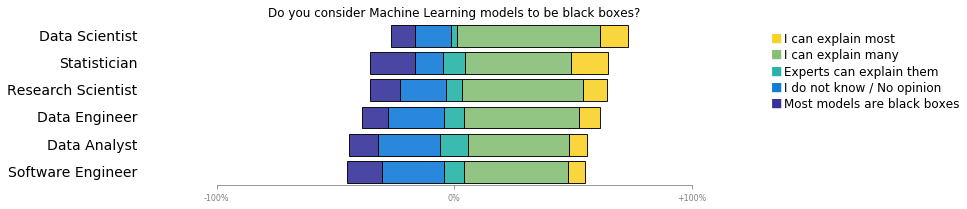

In [10]:
visualize_opinions(q48_data)

#### Observations

* **Statisticians** are the leaders in having the highest number of both the *know-it-all* and *I-know-nothing types*.
* Almost every **Data Scientist** has an opinion on how opaque or black ML models are, somewhat surprisingly **Data Analysts** are the least intrigued by the question.

### How far am I from being a Data Scientist?

Let's take the **Data Scientist** role as a reference and explore the way other roles relate to it. The answers to Question Nr.26 helps us estimate each individual's self assessment:

> Q26 - Do you consider yourself to be a data scientist?

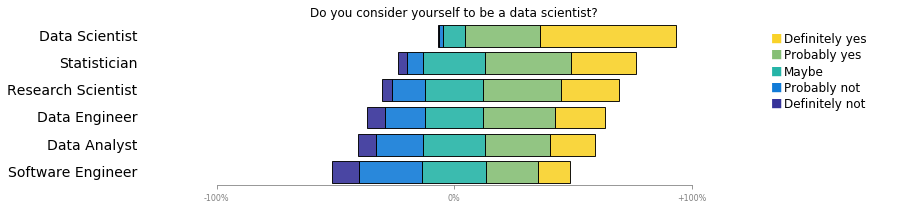

In [11]:
visualize_opinions(q26_data)

Observations:
* Notice that the order of the roles is exactly the same for both answers. Being able to deeply understanding **Machine Learning** models is an essential skill for **Data Scientists**.
* The **Data Scientists** on the left side of the 0 axis are the self-doubters. They picked the **Data Scientist** title when they were asked the first time, but began to question their true identity when facing the question for the second time: "Really? You? Look at yourself! You consider yourself to be a data scientist?"

We can estimate each role's similarity to the **Data Scientist** role using our LDA feature-space by calculating the [Euclidean distance](https://tekmarathon.com/2015/11/15/different-similaritydistance-measures-in-machine-learning/) between the cluster centroids.

Now that we have a general idea of what each role entails and have seen the way they seen themselves, let's plot against each other the "Self Assessed", perceived similarity and the actual similarity between each role and the **Data Scientist** role.

The size of the bubble represents the size of the group, the X axis represents the distance of the group to the **Data Scientist** role measured by self-assessment (Q26 - Are you a Data Scientist?), the Y axis represents the distance of the group to the **Data Scientist** role.

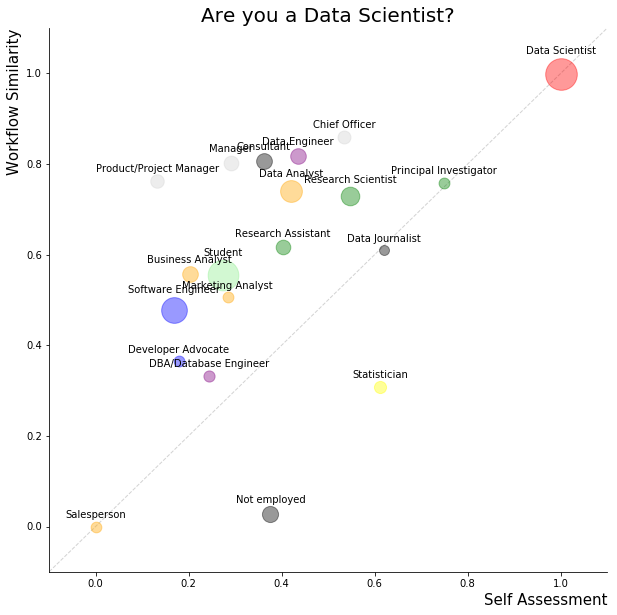

In [12]:
drA = lda.transform(set_roles_original_df)
principalDf = pd.DataFrame(data = drA
             , columns = ['principal component 1', 'principal component 2'], index=set_roles_original_df.index)
finalDf = pd.concat([principalDf, set_roles_original_titles], axis = 1)


mapped_centroids = finalDf.groupby("Q6_original").median()

self_assessment = multi_df.groupby(multi_df["Q6_original"])["Q26"].mean()
self_assessment.index.names=["Role"]
self_assessment.name = "Self Assessment"

distances = pdist(centroids_original, metric='cosine')
dist_matrix = squareform(distances)

centroid_distances = pd.DataFrame(dist_matrix, index = mapped_centroids.index, columns=mapped_centroids.index)
centroid_distances.index.names = ['Role']

data_scientist_similarity = centroid_distances.loc["Data Scientist"]
data_scientist_similarity.name="Similarity"

bubble_plot_data = pd.concat([self_assessment,data_scientist_similarity], axis=1, sort=True)

min_x, min_y = bubble_plot_data.min(axis=0)
max_x, max_y = bubble_plot_data.max(axis=0)
bubble_plot_data_normalized = bubble_plot_data.copy()
bubble_plot_data_normalized["Self Assessment"] = ((bubble_plot_data["Self Assessment"] - min_x)/(max_x-min_x))
bubble_plot_data_normalized["Similarity"] = 1- (bubble_plot_data["Similarity"] - min_y)/(max_y-min_y)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.plot([-2,2], [-2,2],linestyle="--",linewidth=1,color="lightgray", zorder=-10)
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)
ax.set_xlabel("Self Assessment", fontsize = 15, ha="right", x = 1)
ax.set_ylabel("Workflow Similarity", fontsize = 15, ha="right", y=1)
ax.set_title('Are you a Data Scientist?', fontsize = 20)
targets = np.setdiff1d(multi_df["Q6_original"].unique(),["Other"])
dot_size_min = 100
dot_size_max = 1000
#min_y, max_y = ax.get_xlim()
#ax.set_ylim(max_y, min_y)
for target in targets:
    size_p = (sizes[target] - min_size) /(max_size - min_size)
    size = dot_size_min + size_p * (dot_size_max - dot_size_min)
    coords = bubble_plot_data_normalized
    x = bubble_plot_data_normalized.loc[target,"Self Assessment"]
    y =  bubble_plot_data_normalized.loc[target,"Similarity"]
    radius = (size / 3.14) ** 0.5
    ax.scatter([x],[y], c = color_map_original[target],alpha=0.4, s = size)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.annotate(target, 
                xy = (x, y), 
                xytext = (0,2 + radius), 
                textcoords='offset points', 
                horizontalalignment="center")

#### Observations:
 
 * **Statisticians** seem to consider themselves **Data Scientists** despite the differences highlighted in the charts above.
 * **Data Engineers** on the other hand seem to be unaware of how similar their job is to one of a **Data Scientist**.

# Choose the right skills

In the following lines I'm going to dig into data about the **Data Science** job market. I combined the Kaggle Survey Data with a slice of a larger data set I'm currently working on, costisting of more than 1500 Data-related job postings with technology-stack information. The postings were scraped from StackOverflow over the past 2 years. The only information I've kept is the title and the technology stacks. Comparing this set to the survey results gave me the perfect opportunity to explore how the community fullfills the skill demands of the data-job market.

### Evolution of a Data Scientist

**Data Science** is a booming, rapidly evolving field, most of the associated technologies and frameworks are recent and haven't matured yet. For example [Tensorflow](https://www.tensorflow.org/), a leader in symbolic math and neural-network technology was released only 3 years ago. Given the extremely dynamic nature of the **Data Science** technology stacks, I'm going to focus only on developers under 10 years of experience. I believe that above this level technology stacks play a less and less important role in employability, the expectation of knowing a specific set of languages and technologies gives way to less measurable skills such as architecture, management, domain specific experience, and so on.

So let's see for example how the skill stack of a **Data Scientist** evolves over time. I assumed a "blank-page" start, with zero skills, but this is rarely the case. Usually people are already familiar with a few programming languages before starting using the code for data analysis.

I created 5 groups based on the individual's experience:
* Intern - less than 1 year
* Junior - 1-2 years
* Mid-level - 3-5 years
* Senior - 5-10 years
* Veteran - more than 10 years

In [13]:
questions_df = pd.DataFrame(questions)
questions_df.columns=["Q", "Question"]
questions_df.set_index("Q", inplace=True)

def get_skill_from_column_name(questions, column):
    q = questions_df.loc[column,"Question"]
    sp = q.split(" - Selected Choice - ")
    skills = sp[1] if len(sp)>1 else column
    return skills

def get_skill_dict_with_prefix(df, questions, prefix):
    return {get_skill_from_column_name(questions, column):column for column in get_cols_with_prefix(df, prefix )}

skills_ide = get_skill_dict_with_prefix(multi_df, questions, "Q13_Part")
skills_notebook = get_skill_dict_with_prefix(multi_df, questions, "Q14_Part")
skills_cloud_service = get_skill_dict_with_prefix(multi_df, questions, "Q15_Part")
skills_prog_lang = get_skill_dict_with_prefix(multi_df, questions, "Q16_Part")
skills_ml_framework = get_skill_dict_with_prefix(multi_df, questions, "Q19_Part")
skills_dataviz = get_skill_dict_with_prefix(multi_df, questions, "Q21_Part")
skills_cloud_products = get_skill_dict_with_prefix(multi_df, questions, "Q27_Part")
skills_ml_products = get_skill_dict_with_prefix(multi_df, questions, "Q28_Part")
skills_database = get_skill_dict_with_prefix(multi_df, questions, "Q29_Part")
skills_big_data_products = get_skill_dict_with_prefix(multi_df, questions, "Q30_Part")

skill_categories={
    'IDE': skills_ide,
    'Notebook':skills_notebook,
    'Cloud Service':skills_cloud_service,
    'Language':skills_prog_lang,
    'ML Framework':skills_ml_framework,
    'DataViz':skills_dataviz,
    'Cloud Product':skills_cloud_products,
    'ML Product':skills_ml_products,
    'Database':skills_database,
    'Big Data':skills_big_data_products
}

skill_counts =[multi_df[list(skill_category.values())].sum(axis=1) for name, skill_category  in skill_categories.items()]
skill_counts_df = pd.concat(skill_counts, axis=1)
skill_counts_df.columns=list(skill_categories.keys())

stacked_skills_data = skill_counts_df.groupby(multi_df["Q24_Buckets"]).mean()
zeroes = pd.DataFrame([0]*10).T
zeroes.columns = stacked_skills_data.columns
stacked_skills_data = pd.concat([zeroes,stacked_skills_data])
stacked_skills_data.index = ["Novice"] + list(Q24_bucket_labels.values())

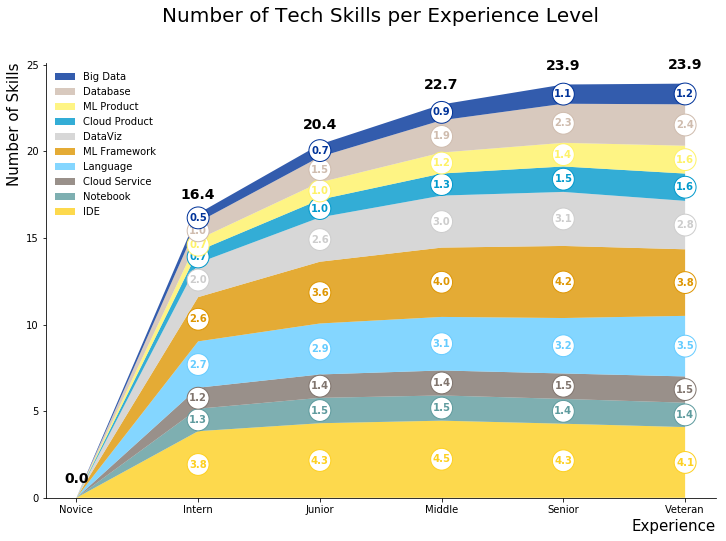

In [14]:


color_scheme = [
    "#fdd021", #candlelight
     "#5e9b9e", #malibu  
    "#80746d", #smalt 
    "#66ccff", #malibu 
    "#de9602",#tangerine
    "#cdcdcd", #silver
    
    "#0099cc", #pacificblue
    "#fef266",#parisdaisy
    "#cfbcae", #softamber   
    "#003399" #smalt 
]

bucket_count = len(stacked_skills_data)
skill_category_count = len(stacked_skills_data.columns)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1,1,1) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(bucket_count))
ax.set_xticklabels(stacked_skills_data.index)
ax.stackplot(np.arange(bucket_count), stacked_skills_data.T.values, colors=color_scheme, labels = stacked_skills_data.columns, alpha=0.8)
ax.tick_params(labelrotation =0)

primary_tick_color = "black"
secondary_tick_color = "gray"
dot_size = 0.18
#totals
for i in range(bucket_count):
    total = stacked_skills_data.iloc[i,:].sum()
    total_text = "%.1f" % total
    ax.text(i,  total+1.1,"{}".format(total_text), ha="center", va="center", fontsize=14, fontweight="bold", color=primary_tick_color)

    
for i in range(bucket_count-1):
    for j in range(skill_category_count):
        value = stacked_skills_data.iloc[i+1,j]
        diff = value - stacked_skills_data.iloc[i,j]
        sign = "+" if diff>0 else ""
        diff_text = "%.1f" % diff
        value_text = "%.1f" % value
        color = color_scheme[j]
        y = stacked_skills_data.iloc[i+1,:j].sum() + value/2
        circle = patches.Ellipse((i+1, y), width=dot_size,
                                         height=7 * dot_size,
                                         linewidth=1,
                                         edgecolor=color,
                                         facecolor='white',
                                         alpha=1,
                                         zorder=j+10
                                         )
        ax.add_patch(circle)
        ax.text(i+1,  y,"{}".format(value_text), ha="center", va="center", fontsize=10, fontweight="bold", color=color, zorder=j+10)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1])

legend.get_frame().set_edgecolor("white")
ax.set_xlabel("Experience", fontsize = 15,  ha="right", x = 1)
ax.set_ylabel("Number of Skills", fontsize = 15,  ha="right", y = 1)
ax.set_title('Number of Tech Skills per Experience Level', fontsize = 20, y=1.08)
plt.show()



#### Observations
* The learning curve is very steep at the beginning but reaches a plateau at Senior level.
* It's interesting to note that **Programming Language** is one category in which knowledge doesn't decline with age. Most of the languages used in Data Science have been around for a very long time. [SQL (1974)](https://en.wikipedia.org/wiki/SQL), [Python (1991)](https://en.wikipedia.org/wiki/Python_(programming_language), [Java (1995)](https://en.wikipedia.org/wiki/Java_(programming_language).

In [15]:
all_skill_categories_flat = { column: label 
                         for categ_name, skill_category in skill_categories.items() 
                         for  label, column in skill_category.items() }

total_individual_skills = multi_df[list(all_skill_categories_flat)]
total_individual_skills.columns = list(all_skill_categories_flat.values())
total_skill_counts = total_individual_skills.sum().sort_values(ascending=False)

#These are obviously not valid Skills
nan_values_to_filter = ["I have not used any cloud providers","None","Other"]

total_skill_pcts = total_skill_counts/len(multi_df)

jobs_df = pd.read_json("./input/jobs.json", orient="index")
all_job_skills = set(item for category_list in jobs_df["categories"].values
              for item in category_list )
all_categories = jobs_df["categories"]
all_skills = [item for category_list in all_categories.values
              for item in category_list ]

similar_skills_to_merge = [
    ["spark","apache-spark"],
    ["python","python-3.x"],
    ["c++","c"],
    ["c#",".net","asp.net"],
    ["javascript",'typescript'],
    ['sql-server','sql-servertsql','sql-server-2012','sql-server-2008-r2','sql-server-2008','microsoft-sql-server','ms-sql-server'],
    ["postgresql",'postgresql-9.4','postgresql-9.6','postgressql'],
    ['reactjs','redux'],
    ["oracle","oracle-database","oracle11g","oracle12c"],
    ["angular","angularjs"],
    ['amazon-web-services','aws'] ,
    ['java','java-ee']
]

def merge_similar_skills(df, skill_lists ):
    
    for skill_list in skill_lists:
        target_column = skill_list[0]
        dropped_columns = skill_list[1:]
        for dropped_column in dropped_columns:
            if (dropped_column in df.columns):
                df[target_column] = df[target_column] | df[dropped_column]
                df.drop(dropped_column, axis=1, inplace=True)
        


mlb = MultiLabelBinarizer()
jobs_df_dummies = pd.DataFrame(mlb.fit_transform(jobs_df["categories"]),
                          columns=mlb.classes_,
                          index=jobs_df.index)

#Merge these columns to match the skills in the Survey

merge_similar_skills(jobs_df_dummies, similar_skills_to_merge)

job_total_skill_counts = jobs_df_dummies.sum()
job_total_skill_pcts = (job_total_skill_counts/len(jobs_df_dummies)).sort_values(ascending=False)

In [16]:
svg_graph = {}

svg_graph[1] = """
<?xml version="1.0" encoding="utf-8"?>
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
 viewBox="0 0 91.7 91.7" style="enable-background:new 0 0 91.7 91.7;" xml:space="preserve">
<g id="CIRCLE">
<path class="st0" d="M38.6,46c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.6,50,38.6,46L38.6,46z"/>
</g>
</svg>
"""

svg_graph[2]="""
<?xml version="1.0" encoding="utf-8"?>
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
 viewBox="0 0 91.7 91.7" style="enable-background:new 0 0 91.7 91.7;" xml:space="preserve">
<g id="LINE_7_">
<line class="st0" x1="46" y1="38.3" x2="46" y2="53.7"/>
</g>
<g id="CIRCLE_1_">
<path class="st0" d="M38.6,61c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3S50,68.3,46,68.3S38.6,65.1,38.6,61L38.6,61z"/>
</g>
<g id="CIRCLE_2_">
<path class="st0" d="M38.6,31c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3S50,38.3,46,38.3S38.6,35,38.6,31L38.6,31z"/>
</g>
</svg>
"""

svg_graph[3]="""
<?xml version="1.0" encoding="utf-8"?>
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
 viewBox="0 0 91.7 91.7" style="enable-background:new 0 0 91.7 91.7;" xml:space="preserve">
<g id="LINE">
<line class="st0" x1="42.2" y1="38" x2="34.5" y2="51.2"/>
</g>
<g id="LINE_1_">
<line class="st0" x1="38.2" y1="57.6" x2="53.5" y2="57.6"/>
</g>
<g id="LINE_2_">
<line class="st0" x1="49.5" y1="38" x2="57.2" y2="51.2"/>
</g>
<g id="CIRCLE_3_">
<path class="st0" d="M38.5,31.6c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.5,35.7,38.5,31.6L38.5,31.6z"/>
</g>
<g id="CIRCLE_4_">
<path class="st0" d="M23.5,57.6c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S23.5,61.6,23.5,57.6L23.5,57.6z"/>
</g>
<g id="CIRCLE_5_">
<path class="st0" d="M53.5,57.6c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S53.5,61.6,53.5,57.6L53.5,57.6z"/>
</g>
</svg>

"""

svg_graph[4]="""
<?xml version="1.0" encoding="utf-8"?>
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
 viewBox="0 0 91.7 91.7" style="enable-background:new 0 0 91.7 91.7;" xml:space="preserve">
<g id="LINE_3_">
<line class="st0" x1="29.8" y1="51" x2="40.6" y2="61.9"/>
</g>
<g id="LINE_4_">
<line class="st0" x1="61.9" y1="51" x2="51" y2="61.9"/>
</g>
<g id="LINE_5_">
<line class="st0" x1="29.8" y1="40.6" x2="40.6" y2="29.8"/>
</g>
<g id="LINE_6_">
<line class="st0" x1="61.9" y1="40.6" x2="51" y2="29.8"/>
</g>
<g id="CIRCLE_6_">
<path class="st0" d="M38.5,67c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.5,71.1,38.5,67L38.5,67z"/>
</g>
<g id="CIRCLE_7_">
<path class="st0" d="M17.3,45.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S17.3,49.9,17.3,45.8L17.3,45.8z"/>
</g>
<g id="CIRCLE_8_">
<path class="st0" d="M59.7,45.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S59.7,49.9,59.7,45.8L59.7,45.8z"/>
</g>
<g id="CIRCLE_9_">
<path class="st0" d="M38.5,24.6c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.5,28.7,38.5,24.6L38.5,24.6z"/>
</g>
</svg>

"""

svg_graph[5]="""
<?xml version="1.0" encoding="utf-8"?>
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
 viewBox="0 0 91.7 91.7" style="enable-background:new 0 0 91.7 91.7;" xml:space="preserve">
<g id="LINE_8_">
<line class="st0" x1="30" y1="51" x2="40.8" y2="61.9"/>
</g>
<g id="LINE_9_">
<line class="st0" x1="62.1" y1="51" x2="51.2" y2="61.9"/>
</g>
<g id="LINE_10_">
<line class="st0" x1="30" y1="40.6" x2="40.8" y2="29.8"/>
</g>
<g id="LINE_11_">
<line class="st0" x1="62.1" y1="40.6" x2="51.2" y2="29.8"/>
</g>
<g id="LINE_12_">
<line class="st0" x1="46" y1="59.7" x2="46" y2="53.2"/>
</g>
<g id="LINE_13_">
<line class="st0" x1="32.1" y1="45.8" x2="38.7" y2="45.8"/>
</g>
<g id="LINE_14_">
<line class="st0" x1="53.4" y1="45.8" x2="59.9" y2="45.8"/>
</g>
<g id="LINE_15_">
<line class="st0" x1="46" y1="38.5" x2="46" y2="31.9"/>
</g>
<g id="CIRCLE_10_">
<path class="st0" d="M38.7,67c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.7,71.1,38.7,67L38.7,67z"/>
</g>
<g id="CIRCLE_11_">
<path class="st0" d="M17.5,45.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S17.5,49.9,17.5,45.8L17.5,45.8z"/>
</g>
<g id="CIRCLE_12_">
<path class="st0" d="M59.9,45.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S59.9,49.9,59.9,45.8L59.9,45.8z"/>
</g>
<g id="CIRCLE_13_">
<path class="st0" d="M38.7,24.6c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.7,28.7,38.7,24.6L38.7,24.6z"/>
</g>
<g id="CIRCLE_14_">
<path class="st0" d="M38.7,45.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.7,49.9,38.7,45.8L38.7,45.8z"/>
</g>
</svg>

"""

svg_graph[6]="""
<?xml version="1.0" encoding="utf-8"?>
<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px"
 viewBox="0 0 91.7 91.7" style="enable-background:new 0 0 91.7 91.7;" xml:space="preserve">
<g id="LINE_16_">
<line class="st0" x1="38.9" y1="43.6" x2="26.9" y2="39.7"/>
</g>
<g id="LINE_17_">
<line class="st0" x1="41.5" y1="51.8" x2="34.2" y2="61.9"/>
</g>
<g id="LINE_18_">
<line class="st0" x1="45.8" y1="38.5" x2="45.8" y2="26"/>
</g>
<g id="LINE_19_">
<line class="st0" x1="25.9" y1="33.1" x2="39.9" y2="23"/>
</g>
<g id="LINE_20_">
<line class="st0" x1="27.6" y1="60.8" x2="22.2" y2="44.4"/>
</g>
<g id="LINE_21_">
<line class="st0" x1="52.8" y1="43.6" x2="64.7" y2="39.7"/>
</g>
<g id="LINE_22_">
<line class="st0" x1="65.8" y1="33.1" x2="51.8" y2="23"/>
</g>
<g id="LINE_23_">
<line class="st0" x1="64.1" y1="60.8" x2="69.4" y2="44.4"/>
</g>
<g id="LINE_24_">
<line class="st0" x1="50.1" y1="51.8" x2="57.5" y2="61.9"/>
</g>
<g id="LINE_25_">
<line class="st0" x1="54.5" y1="67.8" x2="37.2" y2="67.8"/>
</g>
<g id="CIRCLE_15_">
<path class="st0" d="M38.5,45.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S38.5,49.9,38.5,45.8L38.5,45.8z"/>
</g>
<g id="CIRCLE_16_">
<path class="st0" d="M12.6,37.4c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3S24,44.8,20,44.8S12.6,41.5,12.6,37.4L12.6,37.4z"/>
</g>
<g id="CIRCLE_17_">
<path class="st0" d="M38.5,18.6c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3S49.9,26,45.8,26S38.5,22.7,38.5,18.6L38.5,18.6z"/>
</g>
<g id="CIRCLE_18_">
<path class="st0" d="M22.5,67.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S22.5,71.9,22.5,67.8L22.5,67.8z"/>
</g>
<g id="CIRCLE_19_">
<path class="st0" d="M64.4,37.4c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S64.4,41.5,64.4,37.4L64.4,37.4z"/>
</g>
<g id="CIRCLE_20_">
<path class="st0" d="M54.5,67.8c0-4,3.3-7.3,7.3-7.3s7.3,3.3,7.3,7.3s-3.3,7.3-7.3,7.3S54.5,71.9,54.5,67.8L54.5,67.8z"/>
</g>
</svg>

"""

# The skills they need

To find out the other part of the story, let's take a look at the requirements of Data-related job postings. The original data set I used consists of over 30.000 entries. Selecting the ones releveant to the **Data Science** field wasn't a straightforward process. I tried to limit the selection to those containing **Machine Learning**, **Data Science** or **Big Data** related terms. The filtered results can be found in the dataset I published on **Kaggle**. Here is a breakdown of the percentages of numbers of requirements:

In [17]:
skill_requirement_pcts = jobs_df_dummies.sum(axis=1).value_counts(normalize=True)
html = """
<style>
.mv-kpi-container{
display:flex;
justify-content: center;
}
.mv-kpi{
    padding:10px;
    -webkit-box-shadow: 0px 5px 10px 0px rgba(0,0,0,0.28);
    -moz-box-shadow: 0px 5px 10px 0px rgba(0,0,0,0.28);
    box-shadow: 0px 5px 10px 0px rgba(0,0,0,0.28);
    margin:5px;
    display:flex;
    flex-direction:column;
    justify-content:center;
    align-items:center;
    text-align:center;
}
.mv-kpi-value{
    color:#5DADE2;
    font-size:25px;
    font-weight:bold;
    display:block;
    width:100%;
    padding:5px 5px 20px 5px;
   
}
.mv-kpi-value-large{
  color: #5DADE2;
    font-size:80px;
    font-weight:bold;
    display:block;
    width:100%;
    padding:5px;
  
}

.mv-kpi-value-large svg{
    width:100px;
}

.mv-kpi-value-large svg g{
stroke: #5DADE2;
stroke-width:3px;
fill:none;
}
</style>
"""
html += "<div class='mv-kpi-container'>"
for i in range(skill_requirement_pcts.size):
    pct = int(skill_requirement_pcts.iloc[i]*100)
    count = skill_requirement_pcts.index[i]
    html+="<div class='mv-kpi'><span class='mv-kpi-value-large'>"+svg_graph[skill_requirement_pcts.index[i]]+"</span><span class='mv-kpi-value'>{}%</span></div>".format( pct)
html+= "</div>"
display(HTML(html))

#### Observations:
* A quick glance on the data reveals that more than 88% of all job descriptions require at least 3 different skills in the requirements. More than 60% mention 5 different terms the applicant is expected to be familiar with.

Time is limited so we have to decide carefully in which skills to invest it to maximize our chances on the job market. The next section intends to help us select these skills by analysing their frequency in the data set.

### Learn Python. No excuses.

I visualized the top 50 technologies by percent of users familiar with the technology in question (Supply) and percent of job requirements mentioning it (Demand). Technologies which appear in both lists are connected with gray ribbons.
The gray-colored skills are the ones missing from either the Supply or the Demand column. 

I decided not to include some of the terms which I found too general, but nonetheless these concepts are among the top 50 most important things required by employers. In order of importance: `Machine Learning`, `Big Data`, `Cloud`, `Sys Admin`, `Agile`, `Algorithm`, `NoSQL`, `Database`, `Data Science`, `REST`, `Deep Learning`, `Artificial Intelligence`, `Web-Services`, `Testing`, `Computer Vision`, `QA`, `Security`, `Automation`, `Design`, `Microservices`, `DevOps`, `Data Warehouse`, `NLP`, `Statistics`, `ETL`, `Data`, `Neural Network`, `Time Series`, `Data Modeling`, `UI`, `JSON`, `Apache`, `CI` and `API`.


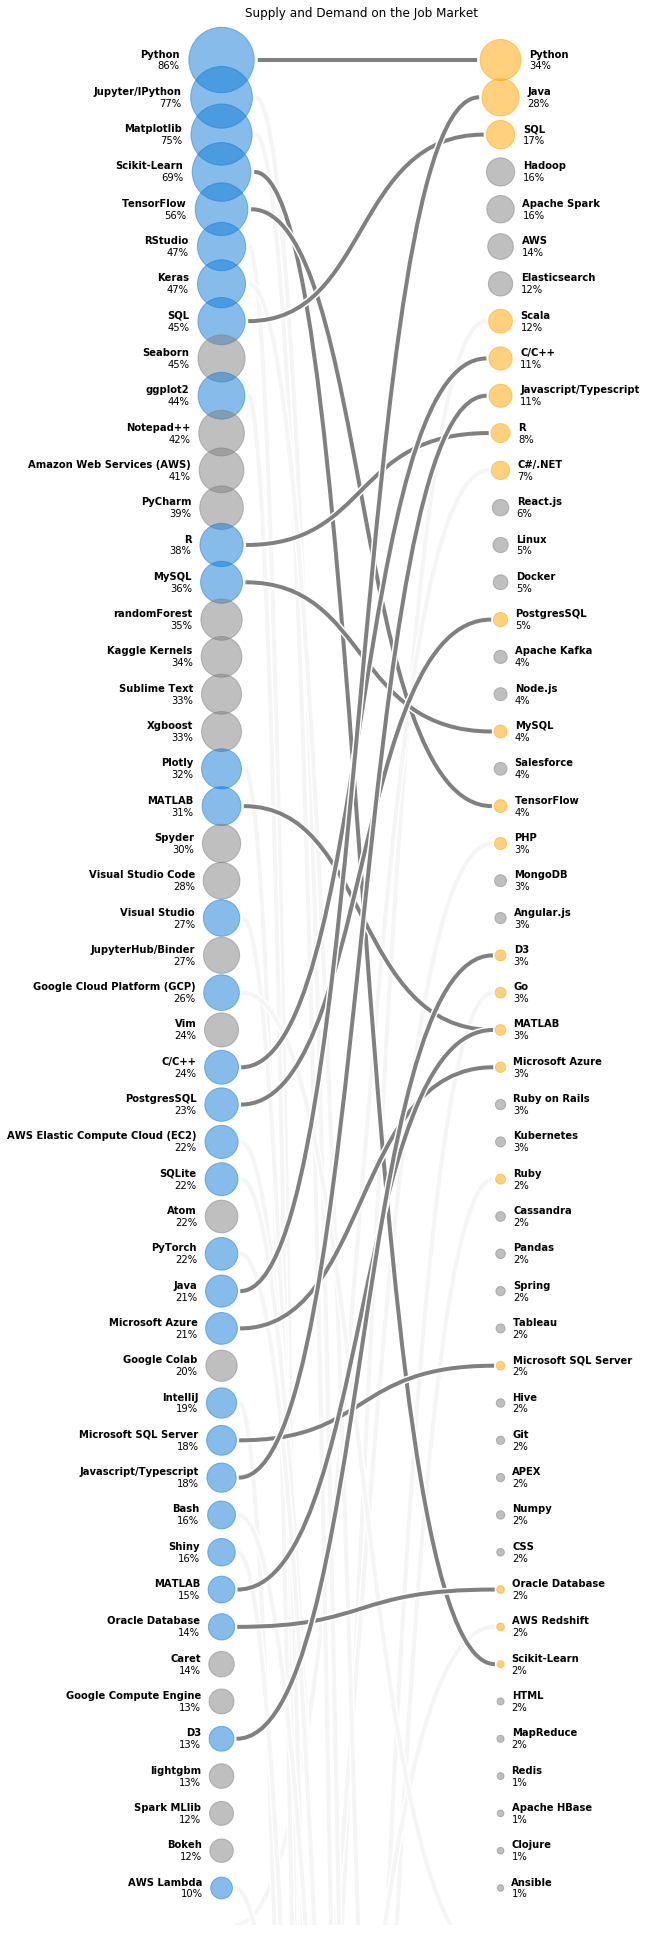

In [18]:
#These terms are too generic, should be filtered
filter_demand_values = [
    "machine-learning",
    "bigdata",
    "cloud",
    "sysadmin",
    "agile",
    "algorithm",
    "nosql",
    "database",
    "data-science",
    "rest",
    "deep-learning",
    "artificial-intelligence",
    "web-services",
    "testing",
    "computer-vision",
    "qa",
    "security",
    "automation",
    "design",
    "microservices",
    "devops",
    "data-warehouse",
    'statistics',
    'nlp',
    'etl',
    'data-mining',
    'data',
    'neural-network',
    'time-series',
    'data-modeling',
    'user-interface',
    'json',
    'apache',
    'continuous-integration',
    'api',
    'automated-tests',
    'project-management',
    'user-experience',
    'sdlc',
    'analytics',
    'xml'
]

renamed_survey_skills = {
    'Amazon Web Services (AWS)':'AWS'
}

from_job_skill_to_survey_skill_map = {
    "jupyter":"Jupyter/IPython",
    "jupyter notebook":"Jupyter/IPython",
    "r-studio":"RStudio",
    "visual-studio-code":"Visual Studio Code",
    "atom":"Atom",
    "atom-ide":"Atom",
    "matlab":"MATLAB",
    "visual-studio":"Visual Studio",
    "notepad++":"Notepad++",
    "sublime-text":"Sublime Text",
    "vim":"Vim",
    "intellij":"IntelliJ",
    "intellij-idea":"IntelliJ",
    "floydhub":"Floydhub",
    "google-cloud-platform":"Google Cloud Platform (GCP)",
    'amazon-web-services':'AWS', 
    'aws': 'AWS',
    'azure': 'Microsoft Azure',
    'microsoft-azure': 'IBM Cloud',
    'r': 'R',
    'sql': 'SQL',
    'bash': 'Bash',
    'java': 'Java',
    'javascript':'Javascript/Typescript', 
    'typescript': 'Javascript/Typescript',
    'vb': 'Visual Basic/VBA',
    'vba':'Visual Basic/VBA', 
    'visual-basic': 'Visual Basic/VBA',
    'c':'C/C++', 
    'c++': 'C/C++',
    'matlab': 'MATLAB',
    'scala': 'Scala',
    'julia': 'Julia',
    'go': 'Go',
    'c#, .net': 'C#/.NET',
    'php': 'PHP',
    'ruby': 'Ruby',
    'sas, sass': 'SAS',
    'scikit-learn': 'Scikit-Learn',
    'tensorflow': 'TensorFlow',
    'keras': 'Keras',
    'pytorch': 'PyTorch',
    'h2o': 'H20',
    'caret': 'Caret',
    'prophet': 'Prophet',
    'caffe':"Caffe",
    'caffe2': 'Caffe',
    'ggplot': 'ggplot2',
    'matplotlib': 'Matplotlib',
    'shiny': 'Shiny',
    'd3.js': 'D3',
    'plotly': 'Plotly',
    'leaflet': 'Leaflet',
    'lattice': 'Lattice',
    'amazon-ec2': 'AWS Elastic Compute Cloud (EC2)',
    'google-compute-engine': 'Google Compute Engine',
    'aws-elastic-beanstalk': 'AWS Elastic Beanstalk', 
    'elastic-beanstalk': 'AWS Elastic Beanstalk',
    'google-app-engine': 'Google App Engine',
    'aws-lambda': 'AWS Lambda',
    'google-cloud-functions': 'Google Cloud Functions',
    'azure-container-service': 'Azure Container Service',
    'azure-functions': 'Azure Functions',
    'azure-eventhub': 'Azure Event Grid',
    'ibm-cloud': 'IBM Cloud Virtual Servers',
    'google-cloud-speech-api': 'Google Cloud Speech-to-text API',
    'rekognition-api': 'Amazon Rekognition',
    'google-cloud-vision-api': 'Google Cloud Vision API',
    'google-cloud-natural-language': 'Google Cloud Natural Language API',
    'amazon-lex': 'Amazon Lex',
    'domino': 'Domino Datalab',
    'cloudera': 'Cloudera',
    'azure-machine-learning': 'Azure Machine Learning Workbench',
    'cortana-intelligence': 'Azure Cortana Intelligence Suite',
    'ibm-watson-cognitive': 'IBM Watson Studio',
    'azure-cognitive-services': 'Azure Cognitive Services',
    'aws-rds': 'AWS Relational Database Service',
    'amazon-aurora': 'AWS Aurora',
    'amazon-rds-aurora': 'AWS Aurora', 
    'aws-aurora': 'AWS Aurora',
    'google-cloud-sql': 'Google Cloud SQL', 
    'google-cloud-sql-for-postgresql': 'Google Cloud SQL',
    'amazon-dynamodb': 'AWS DynamoDB',
    'google-cloud-datastore': 'Google Cloud Datastore',
    'google-cloud-bigtable': 'Google Cloud Bigtable',
    'amazon-simpledb': 'AWS SimpleDB',
    'microsoft-sql-server': 'Microsoft SQL Server',
    'ms-sql-server': 'Microsoft SQL Server',
    'sql-server': 'Microsoft SQL Server', 
    'sql-server-2008': 'Microsoft SQL Server', 
    'sql-server-2008-r2': 'Microsoft SQL Server',
    'sql-server-2012': 'Microsoft SQL Server',
    'sql-servertsql': 'Microsoft SQL Server',
    'mysql': 'MySQL',
    'postgresql': 'PostgresSQL', 
    'postgresql-9.4': 'PostgresSQL', 
    'postgresql-9.6': 'PostgresSQL',
    'postgressql': 'PostgresSQL',
    'sqlite': 'SQLite',
    'oracle': 'Oracle Database',
    'oracle-database': 'Oracle Database',
    'oracle11g': 'Oracle Database',
    'oracle12c': 'Oracle Database',
    'ms-access, access': 'Microsoft Access',
    'nexus': 'NexusDB',
    'azure-cosmos-db': 'Azure Cosmos DB', 
    'azure-cosmosdb': 'Azure Cosmos DB',
    'azure-sql-database': 'Azure SQL Database',
    'azure-database-for-postgresql': 'Azure Database for PostgreSQL',
    'google-cloud-dataflow': 'Google Cloud Dataflow',
    'amazon-kinesis': 'AWS Kinesis',
    'google-cloud-pub/sub': 'Google Cloud Pub/Sub',
    'google-cloud-pubsub': 'Google Cloud Pub/Sub',
    'amazon-athena': 'AWS Athena',
    'amazon-redshift': 'AWS Redshift',
    'google-bigquery': 'Google BigQuery',
    'google-bigquery-data-transfer-service': 'Google BigQuery',
    'teradata': 'Teradata',
    'snowflake': 'Snowflake', 
    'snowflake-datawarehouse': 'Snowflake',
    'databricks': 'Databricks',
    'azure-stream-analytics': 'Azure Stream Analytics',

    'python':'Python',
    'r':'R',
    'sql':'SQL',
    'hadoop':'Hadoop',
    'apache-spark':'Apache Spark',
    'java':'Java',
    'scala':'Scala',
    'tensorflow':'TensorFlow',
    'amazon-web-services':'AWS',

    'pyspark':'PySpark',
    'pandas':'Pandas',
    'spark':'Apache Spark',
    'numpy':'Numpy',

    'linux':'Linux',
    'tableau':'Tableau',
    'http':'HTTP',
    'cassandra':'Cassandra',
    'git':'Git',
    'mongodb':'MongoDB',
    'hive':'Hive',

    'html':'HTML'   ,
    'elasticsearch':'Elasticsearch',
    'reactjs':'React.js',
    'docker':'Docker',
    'apache-kafka':'Apache Kafka',
    'salesforce':'Salesforce',
    'node.js':'Node.js',
    ".net":'.NET',
    'asp.net':'.NET',
    'ruby-on-rails':'Ruby on Rails',
    'kubernetes':'Kubernetes',
    'spring':'Spring',
    'angularjs':'Angular.js',
    "angular":'Angular.js',
    'apex':'APEX',
    'css':'CSS',
    'mapreduce':'MapReduce',
    'redis':'Redis',
    'user-interface':'UI',
    'hbase':'Apache HBase',
    "c#":"C#/.NET",
    'clojure':'Clojure',
    'redux':'Redux',
    'jenkins':'Jenkins',
    'powerbi':'Power BI',
    'jira':'Jira',
    'windows':'Windows',
    'unix':'Unix',
    'vb.net':'VB.net',
    'ansible':'Ansible'
}




x_supply_axis=-0.75
x_demand_axis = 0.75
count = 50

demand = job_total_skill_pcts[~job_total_skill_pcts.index.isin(filter_demand_values)]
supply = total_skill_pcts[~total_skill_pcts.index.isin(nan_values_to_filter)]

demand_labels = [from_job_skill_to_survey_skill_map.get(l,l) for l in demand.index] 

fig, ax = plt.subplots(figsize=(10, 0.7*count))


x_supply = [x_supply_axis]*count
y_supply = list(range(count))

x_demand = [x_demand_axis]*count
y_demand = list(range(count))


supply_values = [math.ceil(supply.iloc[i]*100) for i in range(count)]
demand_values = [math.ceil(demand.iloc[i]*100) for i in range(count)]

area_coef = 5000
area_supply = (supply*area_coef).values
area_demand = (demand*area_coef).values

supply_radius = [((size / 3.14) ** 0.5)/200 for size in area_supply]
demand_radius = [((size / 3.14) ** 0.5)/200 for size in area_demand]

center_offset = 0.18

#x_supply = [x_supply[i] - supply_radius[i] + center_offset for i in range(count)]
#x_demand = [x_demand[i] + demand_radius[i] - center_offset for i in range(count)]

existing_color="gray"
missing_color="whitesmoke"

text_offset=0.04 #horizontal offset between bubble and text
supply_colors = []
demand_colors = []
text_vertical_offset = 0.16 #vertical offset between bubble center and text center
for i in range(count):
    supply_label =supply.index[i]
    demand_label=demand_labels[i]
    supply_value=supply_values[i]
    demand_value=demand_values[i]
    x = x_supply_axis - supply_radius[i] -text_offset
    y = i-text_vertical_offset
    ax.text(x, y, supply_label, horizontalalignment="right", verticalalignment="center", fontweight="bold")
    x = x_supply_axis - supply_radius[i]-text_offset
    y = i+text_vertical_offset
    ax.text(x, y ,"{}%".format(supply_value) , horizontalalignment="right", verticalalignment="center")
    
    x = x_demand_axis + demand_radius[i]+text_offset
    y = i-text_vertical_offset
    ax.text(x,y , demand_label, horizontalalignment="left",verticalalignment="center",fontweight="bold")
    x = x_demand_axis + demand_radius[i]+text_offset
    y = i+text_vertical_offset
    ax.text(x, y, "{}%".format(demand_value), horizontalalignment="left",verticalalignment="center")
    supply_colors.append("#117bd7" if supply_label in demand_labels else "gray")
    demand_colors.append("orange" if demand_label in supply.index else "gray")
    
    line_start_offset = 0.01
    line_offset = 0.8
    if supply_label in demand_labels:
        target_index = demand_labels.index(supply_label)
        c = existing_color if supply_label in demand_labels[:count] else missing_color
        vertices = [(x_supply_axis+line_start_offset + supply_radius[i], i), 
              (x_supply_axis+line_offset, i), 
              (x_demand_axis-line_offset, target_index), 
              (x_demand_axis-line_start_offset - demand_radius[target_index], target_index)]
        curves = [Path.MOVETO, Path.CURVE4,Path.CURVE4, Path.CURVE4]
        ax.add_patch(patches.PathPatch( Path(vertices,curves), fc="none", transform=ax.transData, color="white", linewidth=7))
        ax.add_patch(patches.PathPatch( Path(vertices,curves), fc="none", transform=ax.transData, color=c, linewidth=4))
        
    if (demand_label in supply.index) and not (demand_label in supply.index[:count]):
        c= missing_color
        target_index = list(supply.index).index(demand_label)
        vertices= [(x_supply_axis+line_start_offset + supply_radius[target_index], target_index), 
              (x_supply_axis+line_offset, target_index), 
              (x_demand_axis-line_offset, i), 
              (x_demand_axis-line_start_offset - demand_radius[i], i)]
        curves = [Path.MOVETO, Path.CURVE4,Path.CURVE4, Path.CURVE4]
        zorder = -100
        ax.add_patch(patches.PathPatch(Path(vertices,curves), 
                                        fc="none", 
                                        transform=ax.transData, 
                                        color="white", 
                                        linewidth=7,
                                        zorder=zorder))
        ax.add_patch(patches.PathPatch(Path(vertices,curves), 
                                        fc="none", 
                                        transform=ax.transData, 
                                        color=c, 
                                        linewidth=4,
                                        zorder=zorder))



ax.scatter(x_supply, y_supply, s=area_supply, alpha=0.5, c=supply_colors)
ax.scatter(x_demand, y_demand, s=area_demand, alpha=0.5, c=demand_colors)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(count, -1)
ax.set_title("Supply and Demand on the Job Market")
plt.show()

 #### Skill importance by role
The importance of each skill varies between the roles, so while it's useful to have an overview, breaking down the supply and demand by job title gives us a more valuable insight:

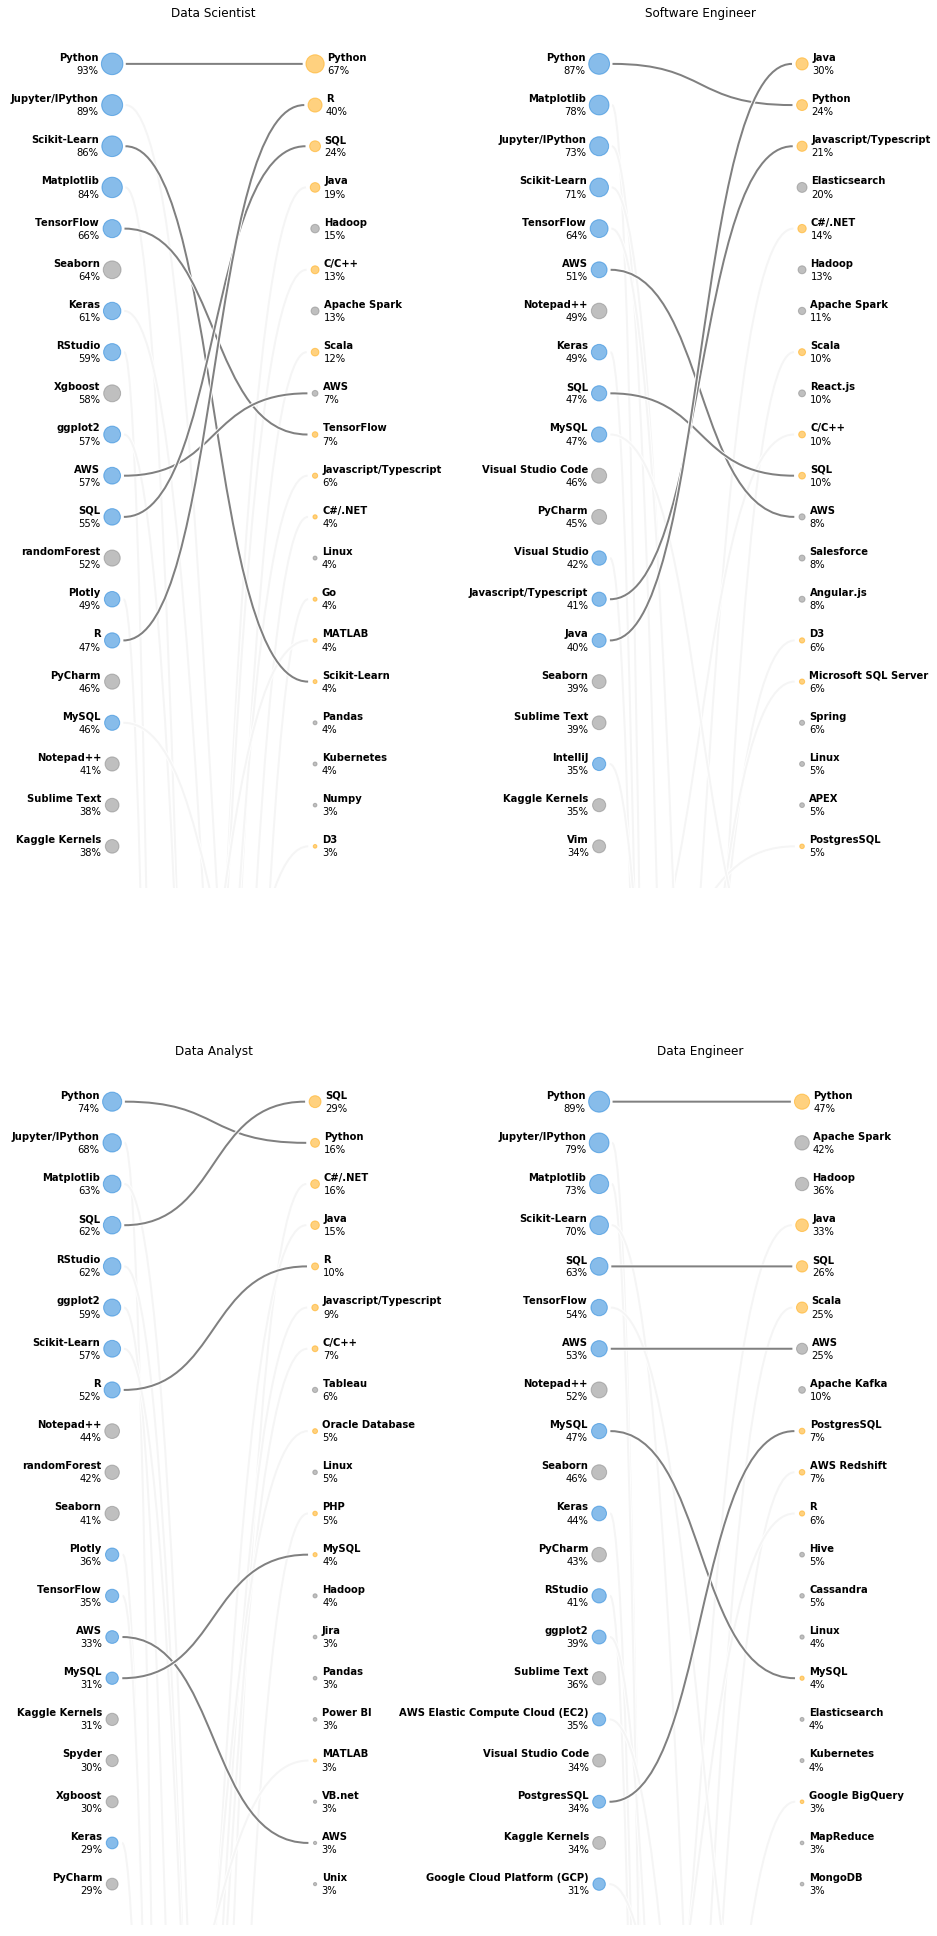

In [19]:
plots = [
    [("Data Scientist","Scien"),
    ("Software Engineer","Developer")],
    [("Data Analyst","Analyst"),
    ("Data Engineer","Data Engineer")]
]
fig, axarr = plt.subplots(2,2, sharex=True, figsize=(8*2, 0.7*count))
for pi in range(2):
    row = plots[pi]
    for pj in range(2):
        role, keyword = row[pj]
        mask = jobs_df["title"].str.contains(keyword)
        masked_dummy_counts = jobs_df_dummies[mask].sum()
        masked_job_total_skill_pcts = (masked_dummy_counts/len(jobs_df_dummies[mask])).sort_values(ascending=False)

        supply_mask = multi_df[C_TITLE]==role
        supply_masked_dummy_counts = total_individual_skills[supply_mask].sum()
        masked_supply_total_skill_pcts = (supply_masked_dummy_counts/len(total_individual_skills[supply_mask])).sort_values(ascending=False)


        count = 20

        ax = axarr[pi,pj]

        demand = masked_job_total_skill_pcts[~masked_job_total_skill_pcts.index.isin(filter_demand_values)]
        supply = masked_supply_total_skill_pcts[~masked_supply_total_skill_pcts.index.isin(nan_values_to_filter)]
        demand_labels = [from_job_skill_to_survey_skill_map.get(l,l) for l in demand.index]
        supply_labels = [renamed_survey_skills.get(l,l) for l in supply.index]
        #fig, ax = plt.subplots(figsize=(8, 0.7*count))

        x_supply = [x_supply_axis]*count
        y_supply = list(range(count))

        x_demand = [x_demand_axis]*count
        y_demand = list(range(count))


        supply_values = [math.ceil(supply.iloc[i]*100) for i in range(count)]
        demand_values = [math.ceil(demand.iloc[i]*100) for i in range(count)]

        area_coef = 500
        area_supply = (supply*area_coef).values
        area_demand = (demand*area_coef).values

        supply_radius = [((size / 3.14) ** 0.5)/200 for size in area_supply]
        demand_radius = [((size / 3.14) ** 0.5)/200 for size in area_demand]

        center_offset = 0.18


        existing_color="gray"
        missing_color="whitesmoke"

        text_offset=0.04 #horizontal offset between bubble and text
        supply_colors = []
        demand_colors = []
        text_vertical_offset = 0.16 #vertical offset between bubble center and text center
        for i in range(count):
            supply_label =supply_labels[i]
            demand_label=demand_labels[i]
            supply_value=supply_values[i]
            demand_value=demand_values[i]
            x = x_supply_axis - supply_radius[i] -text_offset
            y = i-text_vertical_offset
            ax.text(x, y, supply_label, horizontalalignment="right", verticalalignment="center", fontweight="bold")
            x = x_supply_axis - supply_radius[i]-text_offset
            y = i+text_vertical_offset
            ax.text(x, y ,"{}%".format(supply_value) , horizontalalignment="right", verticalalignment="center")

            x = x_demand_axis + demand_radius[i]+text_offset
            y = i-text_vertical_offset
            ax.text(x,y , demand_label, horizontalalignment="left",verticalalignment="center",fontweight="bold")
            x = x_demand_axis + demand_radius[i]+text_offset
            y = i+text_vertical_offset
            ax.text(x, y, "{}%".format(demand_value), horizontalalignment="left",verticalalignment="center")
            supply_colors.append("#117bd7" if supply_label in demand_labels else "gray")
            demand_colors.append("orange" if demand_label in supply.index else "gray")

            line_start_offset = 0.04
            line_offset = 0.8
            if supply_label in demand_labels:
                target_index = demand_labels.index(supply_label)
                c = existing_color if supply_label in demand_labels[:count] else missing_color
                vertices = [(x_supply_axis+line_start_offset + supply_radius[i], i), 
                      (x_supply_axis+line_offset, i), 
                      (x_demand_axis-line_offset, target_index), 
                      (x_demand_axis-line_start_offset - demand_radius[target_index], target_index)]
                curves = [Path.MOVETO, Path.CURVE4,Path.CURVE4, Path.CURVE4]
                ax.add_patch(patches.PathPatch( Path(vertices,curves), fc="none", transform=ax.transData, color="white", linewidth=4))
                ax.add_patch(patches.PathPatch( Path(vertices,curves), fc="none", transform=ax.transData, color=c, linewidth=2))

            if (demand_label in supply.index) and not (demand_label in supply.index[:count]):
                c= missing_color
                target_index = list(supply.index).index(demand_label)
                vertices= [(x_supply_axis+line_start_offset + supply_radius[target_index], target_index), 
                      (x_supply_axis+line_offset, target_index), 
                      (x_demand_axis-line_offset, i), 
                      (x_demand_axis-line_start_offset - demand_radius[i], i)]
                curves = [Path.MOVETO, Path.CURVE4,Path.CURVE4, Path.CURVE4]
                zorder = -100
                ax.add_patch(patches.PathPatch(Path(vertices,curves), 
                                                fc="none", 
                                                transform=ax.transData, 
                                                color="white", 
                                                linewidth=4,
                                                zorder=zorder))
                ax.add_patch(patches.PathPatch(Path(vertices,curves), 
                                                fc="none", 
                                                transform=ax.transData, 
                                                color=c, 
                                                linewidth=2,
                                                zorder=zorder))



        ax.scatter(x_supply, y_supply, s=area_supply, alpha=0.5, c=supply_colors)
        ax.scatter(x_demand, y_demand, s=area_demand, alpha=0.5, c=demand_colors)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(count, -1)
        ax.set_title(role)

plt.show()


#### Observations:
    
* Learn `Python`. No excuses. [Pandas](https://pandas.pydata.org/) and [Numpy](https://www.numpy.org/), its most important data-wrangling libraries also appear on the top 50 list.
* Most **IDE**s, notebooks and data visualization libraries are never mentioned in job requirements. 
* On the other hand [Hadoop](https://hadoop.apache.org/), [Spark](https://spark.apache.org/) and [Elasticsearch](https://www.elastic.co/) are some of the most sought-after technologies on the job market, but were not mentioned in the Survey. Other **Big Data** technologies which appear in the top 50 are: [Hive](https://hive.apache.org/), [Cassandra](http://cassandra.apache.org/), [Kubernetes](https://kubernetes.io/) and [Kafka](https://kafka.apache.org/).
* **Java** is important, but its importance in the global ranking may be exaggerated by the large proportion of **Software-Engineering** jobs in the dataset. The same with **Javascript**, **React** and **Angular**. These jobs were picked because they form in a way part of the data-pipeline, but they tend to over-inflate the presence of some techs in the list.
* **OS** usage was not surveyed, but it's important to note that **Linux** is in demand, mentioned in over 5% of all data-related job requirements.
* [Tableau](https://www.tableau.com/) was not mentioned in the survey among the data-visualization tools, even though based on **Google Trends**, [it is more than 2 times more popular](https://trends.google.com/trends/explore?geo=US&q=learn%20tableau,learn%20matplotlib) than the most popular **Python** dataviz tool, **Matplotlib**. Its language-agnostic, versatile, easy to learn and it's on the rise. 
* **Git** and [Docker](https://www.docker.com/) are in my opinion indispensable tools. Even though they appear only in the bottom half of the list, they should be among the first skills to aquire for a developer.

In [20]:
mapped_categories = jobs_df["categories"].apply(lambda row: [from_job_skill_to_survey_skill_map.get(skill, skill) for skill in row])

skill_counts_per_experience_bucket = skill_counts_df.groupby([multi_df[C_TITLE],multi_df["Q24_Buckets"]]).mean().astype(int)

def get_average_skill_count_by_title_and_exp(job_title, experience_level):
    by_job_title = skill_counts_per_experience_bucket.loc[job_title]
    columns = skill_counts_per_experience_bucket.columns
    return by_job_title.loc[experience_level] if experience_level in by_job_title.index else pd.Series(np.zeros(len(columns)),index = columns)

def get_total_skill_popularity(job_title, experience_level):
    df = pd.DataFrame(total_individual_skills[(multi_df[C_TITLE]==job_title) & (multi_df["Q24_Buckets"]==experience_level)].mean())
    df["Category"] = [cat for cat, category_list in skill_categories.items() for skill in category_list]
    return df

def get_most_probable_skill_stack(job_title, experience_level):
    avg_skill_count = get_average_skill_count_by_title_and_exp( job_title, experience_level)
    skill_popularity = get_total_skill_popularity(job_title,experience_level)
    stack = {}
    for category in avg_skill_count.index:
        get_count = avg_skill_count[category]
        if get_count == 0:
            stack[category] = []
        else:
            mask = (skill_popularity["Category"]==category)& ~(skill_popularity.index.isin(nan_values_to_filter))
            stack[category]=list( skill_popularity[mask].sort_values(by=0, ascending=False).head(get_count).index)
    return stack

def get_category_counts_until_next_level(job_title, experience_level):
    avg_skill_count = get_average_skill_count_by_title_and_exp( job_title, experience_level)
    avg_skill_count_next = get_average_skill_count_by_title_and_exp( job_title, experience_level+1)
    diff = avg_skill_count_next-avg_skill_count
    diff[diff < 0] = 0
    return diff.astype(int)

def get_employability_from_stack(stack):
    all_skills_from_stack = {skill for category, category_list in stack.items() for skill in category_list}
    match_count = mapped_categories.apply(lambda skills: len(set(skills)&all_skills_from_stack))
    match_points = match_count * (match_count+1)/2
    return match_points.sum()

def fill_stack(stack, counts):
    

    #counts = The number of skills to add to each category
    
    
    #set up a DF with zero counts
    skill_counts = pd.DataFrame(list(all_skill_categories_flat.values()), columns=["Skill"])
    skill_counts["Count"] = 0
    skill_counts.set_index("Skill", inplace=True)
    
    for category_list in jobs_df["categories"].values:
        all_skills_from_stack = {skill for category, category_list in stack.items() for skill in category_list}
        match_count = len(set(all_skills_from_stack)&set(category_list))
        of_total_count = len(set(category_list))
        is_matched = match_count > 0
        for skill in category_list:
                mapped_name = from_job_skill_to_survey_skill_map.get(skill,skill)
                if not mapped_name in skill_counts.index.values:
                    continue
                else:
                    #The job was already matched, now we increase the fill
                    if not is_matched:
                        skill_counts.loc[mapped_name,"Count"] = skill_counts.loc[mapped_name,"Count"] + match_count+1 #skill_counts.loc[mapped_name,"Count"] + 1
                    else:
                        skill_counts.loc[mapped_name,"Count"] = skill_counts.loc[mapped_name,"Count"] + match_count+1 #skill_counts.loc[mapped_name,"Count"] + 1/len(category_list)

    skill_counts["Category"]= [cat for cat, category_list in skill_categories.items() for skill in category_list]
    skill_counts
    new_stack = copy.deepcopy(stack)
    for category in counts.index:
        count = counts[category]
        picked = skill_counts[(skill_counts["Category"]==category)&
                              ~(skill_counts.index.isin(nan_values_to_filter))&
                              ~(skill_counts.index.isin(all_skills_from_stack ))
                             ].sort_values(by="Count", ascending=False).head(count).index.values
        new_stack[category].extend(picked)
    
    return new_stack

stack_css = """
    <style>
        .mv-stack-container{
            display:flex;
            height:700px;
            width:100%;
        }
        .mv-stack-symbol{
            display:flex;
            height:100%;
            align-items:center;
            justify-content:center;
            font-size:30px;
            font-weight:bold;
            color:#5DADE2;
        }
        .mv-stack-categories{
            display:flex;
            height:100%;
            align-items:flex-start;
            justify-content:center;
            padding:20px;
            width:30%;
            flex-grow:1;
        }
        .mv-stack-unknown{
            max-width:240px;
            align-items:center;
        }
        .mv-stack-table{
            display:table;
        }
        .mv-stack-row{
            
            padding:5px 0px;
            display: flex;
            flex-direction: column;
            align-items: flex-start;
        }
        
        .mv-stack-row-title{
            font-size: 20px;
            font-weight: bold;
            color: #5DADE2;
            padding: 10px 0px;
        }
        .mv-stack-row-metric{
            font-size: 30px;
            font-weight: bold;
            color: #5DADE2;
            padding: 10px 0px;
        }
        
        .mv-stack-row.mv-stack-unknown{
            display:table-row;
        }
        .mv-stack-cell{
            display:table-cell;
            
        }
        .mv-stack-cell-title{
            display:table-cell;
            text-align:right;
            font-weight:bold;
            font-size:12px;
            margin-bottom: -4px;
        }
        
        .mv-stack-cell-title.mv-stack-unknown{
            padding:5px;
        
        }
        .mv-stack-skill{
            background:#5DADE2;
            color:white;
            border-radius:3px;
            padding: 2px 4px;
            margin:0px 4px 2px 0px;
            font-size:12px;
            white-space:nowrap;
            display:inline-block;
            line-height:1.2rem;
        }
        
        .mv-stack-skill-empty{
            background:darkgray;
        }
        .mv-stack-skill-unknown{
            background:black;
            color:white;
        }
        
    </style>
    """

skill_category_color_scheme = {list(skill_categories.keys())[i]:color_scheme[i] for i in range(len(color_scheme))}

from IPython.core.display import display, HTML


def visualize_stack(before_stack_name, before_stack, after_stack_name, after_stack, category_counts):
    html = stack_css
    html+= "<div class='mv-stack-container'>"
    html+=visualize_single_stack(before_stack, before_stack_name)
    html+=visualize_new_skills(category_counts)
    html+=visualize_single_stack(after_stack, after_stack_name)    
    html+= "</div>"
    
    display(HTML(html))

def visualize_new_skills(category_counts):
    html=  """  <div class='mv-stack-symbol'>+</div>
                <div class='mv-stack-categories mv-stack-unknown'>
                    <div class='mv-stack-table'>"""
    for i in range(len(category_counts)):
        if category_counts[i]==0: 
            continue
        html+=  "<div class='mv-stack-row mv-stack-unknown'>"
        html+=  "    <div class='mv-stack-cell-title mv-stack-unknown'>{}</div>".format(category_counts.index[i])
        html+=  "    <div class='mv-stack-cell'>"
        for j in range(category_counts[i]):
            html+=  "    <span class='mv-stack-skill mv-stack-skill-unknown'>?</span>"      
        html+=  "    </div>"      
        html+=  "</div>"               
    html+=  """
            </div>
        </div>
        <div class='mv-stack-symbol'>=</div>"""
    return html

def visualize_single_stack(stack, title):
    score = int(get_employability_from_stack(stack))
    html="""<div class='mv-stack-categories'>
            <div class='mv-stack-table'>
                <div class='mv-stack-row-title'>{}</div>
                <div class='mv-stack-row-metric'>{} points</div>
            """.format(title, score)
    for category, skills in stack.items():
        #color = skill_category_color_scheme[category]
        html+="""
        <div class='mv-stack-row'>
        <div class='mv-stack-cell-title'>{}</div>
        <div class='mv-stack-cell' >""".format(category)
        if not len(skills):
            html+="<span class='mv-stack-skill mv-stack-skill-empty' >{}</span>".format("None")
        else:
            for skill in sorted(skills):
                html+="<span class='mv-stack-skill' >{}</span>".format(skill)
                    
        html+=   """</div> </div> """
    
    html+=  """
            </div>
        </div>
        """
    return html
    
def visualize_role_options(job_title, level, before_label, after_label):
    before_stack = get_most_probable_skill_stack(job_title, level)
    counts = get_category_counts_until_next_level(job_title,level)
    after_stack = fill_stack(before_stack,counts)

    visualize_stack(before_label,
                    before_stack, 
                    after_label,
                    after_stack, 
                    counts)
    
def visualize_stacks(stacks, titles):
    html = stack_css
    html+= "<div class='mv-stack-container'>"
    for i in range(len(stacks)):
        html+=visualize_single_stack(stacks[i], titles[i])
    html+= "</div>"
    
    display(HTML(html))

### Learning order

Nobody in their right mind would start learning programming by working with **MapReduce** or **Hadoop**. Yout first need to learn the ABC before starting writing a novel, they say. So if there is a natural order in learning these skills, can we reveal this underlying sequentiality from the data?

[Association Rules](https://en.wikipedia.org/wiki/Association_rule_learning) might give us some answers. The goal of **Association Rule Mining** is the identification of patterns of cooccurrences between items based on their individual occurrence probability vs. their simultaneous occurrence probability. If **RStudio** for example appears in almost every stack where **R** is present, but the opposite is not true, we could presume that **R** is a prerequisite for **RStudio**. 
Here is a graph of the associations identified above a predefined confidence threshold, the weight of the edges represent the confidence, the size of the nodes and the vertical position both represent the occurrence frequency of that specific skill.

In [21]:
all_skill_categories_flat_filtered = {column:skill for column, skill in all_skill_categories_flat.items() if skill not in nan_values_to_filter}
skills_studied = all_skill_categories_flat_filtered
p_skill = pd.DataFrame(multi_df[list(skills_studied.keys())].mean())
p_skill.index = list(skills_studied.values())

p_skill.index.name = "From"
p_skill.columns=["p"]
skill_pairs = multi_df[list(skills_studied.keys())]
skill_pairs.columns = list(skills_studied.values())
p_skill_pair = skill_pairs.T.dot(skill_pairs)/len(skill_pairs)
p_skill_pair = pd.DataFrame(p_skill_pair.unstack())
p_skill_pair.index.rename(["From","To"], inplace=True)
p_skill_pair.columns=["p_both"]

from  itertools import combinations

combo = list(combinations(range(len(p_skill.index)),2))
i1 = [i1 for i1,i2 in combo]
i2 = [i2 for i1,i2 in combo]
assoc_rules_data= pd.DataFrame({'From':p_skill.index[i1],'To':p_skill.index[i2],'p_from':p_skill.iloc[i1,0].values,'p_to':p_skill.iloc[i2,0].values})

assoc_rules = pd.DataFrame(assoc_rules_data)
assoc_rules.set_index(["From","To"], inplace=True)

p_skill_pair = p_skill_pair[~p_skill_pair.index.duplicated(keep='first')]
assoc_rules= assoc_rules[~assoc_rules.index.duplicated(keep='first')]

assoc_rules = pd.concat([assoc_rules, p_skill_pair], sort=True, axis=1)
#assoc_rules["support"] = p_skill_pair.values
assoc_rules["confidence"]= assoc_rules["p_both"]/assoc_rules["p_to"]
assoc_rules["lift"] = assoc_rules["p_both"]/(assoc_rules["p_from"]*assoc_rules["p_to"])
assoc_rules.loc[assoc_rules["confidence"]==1,"lift"]=np.nan

assoc_rules_not_null = assoc_rules.dropna()
#Drop identical and inverted rules
assoc_rules_not_null_filtered =assoc_rules_not_null[
    (assoc_rules_not_null.index.get_level_values(0)!=assoc_rules_not_null.index.get_level_values(1))&
    (assoc_rules_not_null["p_from"]>assoc_rules_not_null["p_to"])
]

#Limit input count
input_count = 2

#Limit output count
output_count = 8

assoc_rules_not_null_grouped = assoc_rules_not_null_filtered.groupby(
    assoc_rules_not_null_filtered.index.get_level_values(1), as_index=False
).apply(lambda g: g.sort_values(by="confidence", ascending=False).head(input_count)).reset_index(0, drop=True)

assoc_rules_not_null_top = assoc_rules_not_null_grouped.groupby(
    assoc_rules_not_null_grouped.index.get_level_values(0), as_index=False
).apply(lambda g: g.sort_values(by="confidence", ascending=False).head(output_count)).reset_index(0, drop=True)


selected_assoc_rules = assoc_rules_not_null_top[
    (assoc_rules_not_null_top["p_both"]>0.05)&
    (assoc_rules_not_null_top["lift"]>0.2)
].sort_values(by="confidence", ascending=False).head(100)


all_selected_nodes = set(list(selected_assoc_rules.index.get_level_values(0)) + list(selected_assoc_rules.index.get_level_values(1)))
all_nodes = [(index, {'size':p_skill.loc[index]["p"].mean()}) for index in all_selected_nodes]
output_counts = selected_assoc_rules.groupby(selected_assoc_rules.index.get_level_values(0)).size()
input_counts = selected_assoc_rules.groupby(selected_assoc_rules.index.get_level_values(1)).size()


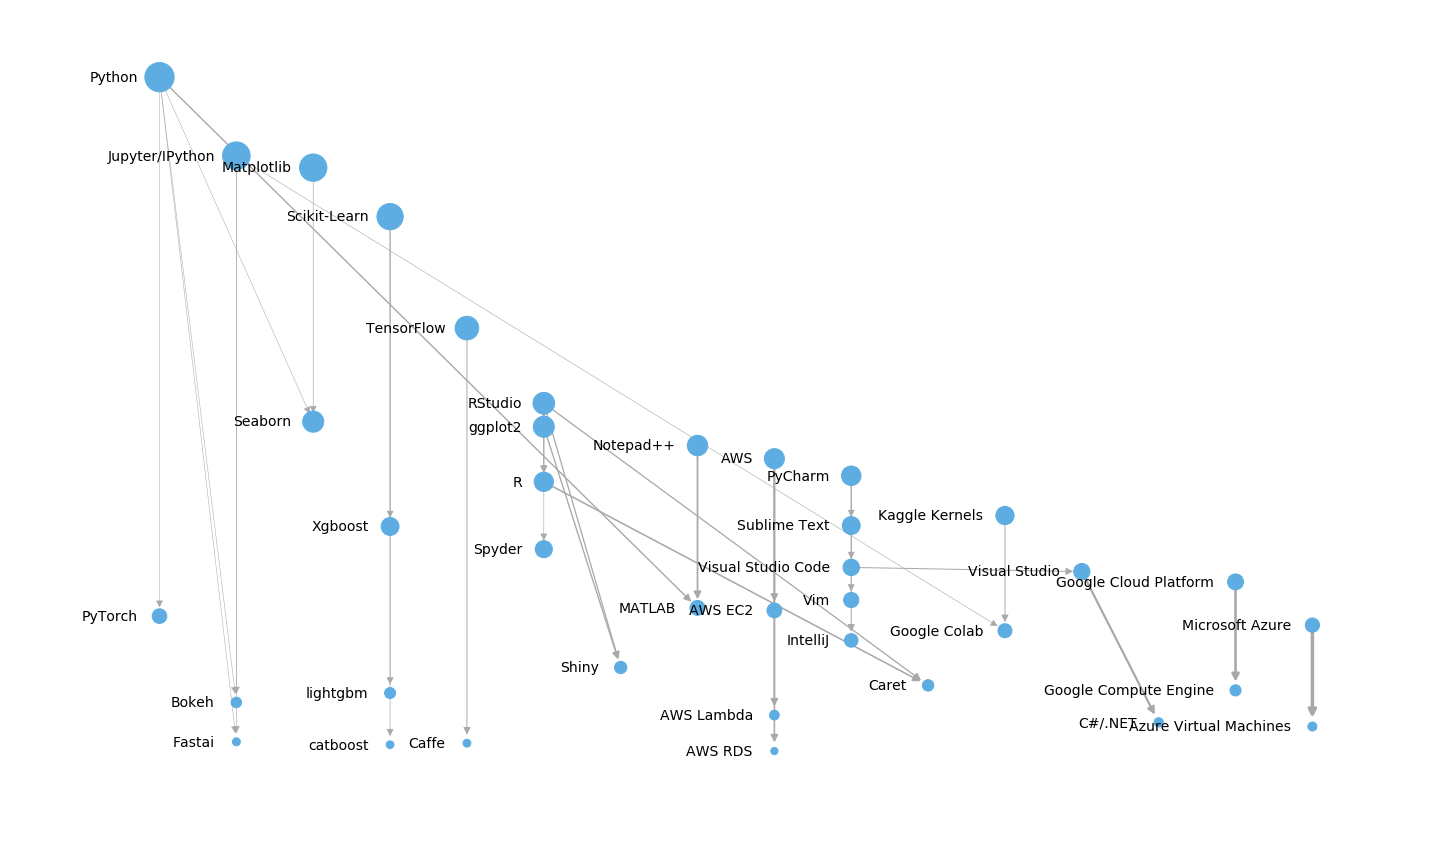

In [22]:
import networkx as nx

plt.figure(figsize=(25,15))
G = nx.DiGraph()
G.add_nodes_from(all_nodes)


for row in selected_assoc_rules.reset_index().values:
    G.add_edge(str(row[0]),str(row[1]),weight = row[6])

    
roots = {n: list(G.predecessors(n)) for n,attr in G.nodes(data="size")}
root_names =  {n:n if len(predecessors)==0 else predecessors[-1] for n,predecessors in roots.items()}
root_sizes = {n: G.nodes[n]["size"] if len(predecessors)==0 else  G.nodes[predecessors[-1]]["size"] for n,predecessors in roots.items()}
import operator

nodes_sorted = sorted({n:attr["size"] for (n, attr) in all_nodes}.items(), key=operator.itemgetter(1), reverse=False)
roots_sorted = [n for n, size in nodes_sorted if n in root_names.values()]

all_nodes_names = sorted([n for (n, attr) in all_nodes])
pos_initial = {n:(input_counts[n] if n in input_counts else 0,all_nodes_names.index(n)/100) for (n, attr) in all_nodes}
#pos_initial = {n:(-attr["size"],all_nodes_names.index(n)/100) for (n, attr) in all_nodes}
pos_initial = {n:(-output_counts[n]*attr["size"] if n in output_counts else 0,all_nodes_names.index(n)/100) for (n, attr) in all_nodes}

pos_initial = {n:(
     -roots_sorted.index(root_names[n])/10,
    attr["size"]*10
) for (n, attr) in all_nodes}

pos = nx.spring_layout(G,weight='weight',k=5, pos=pos_initial, iterations=0)

node_sizes = node_size=[attr["size"]*1000 for (n, attr) in all_nodes]

nx.draw_networkx_nodes(G, pos, node_size =node_sizes , node_color="#5DADE2")

weights = [w for (f,t,w) in G.edges(data="weight")]
min_w = min(weights)
max_w = max(weights)



edge_intensity = [0.5 + ((w - min_w)/(max_w-min_w))*3 for w in weights]

nx.draw_networkx_edges(G, pos,arrows=True,arrowsize=15, arrowstyle='-|>', 
                       width =edge_intensity,
                       edge_color="darkgray",
                       edge_cmap = plt.cm.Greys)
y_offset=0.000
x_offset = -0.005

#These are too long
replace_labels = {
    'AWS Elastic Compute Cloud (EC2)':'AWS EC2',
    'AWS Relational Database Service':'AWS RDS',
    'Amazon Web Services (AWS)':'AWS',
    'Google Cloud Platform (GCP)':'Google Cloud Platform'
}
labels = dict((n, replace_labels.get(n,n)) for n in G.nodes())

label_pos = {node:[coords[0]+x_offset,coords[1]+y_offset] for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos,labels = labels,horizontalalignment = "right", font_size=14)
plt.axis('off')
plt.show()

#### Observations
*  Most of the identified associations seem to be valid prerequisite relationships, for example **Seaborn** is built as an abstraction over the **Matplotlib** API and there is no **Shiny** without **RStudio**. Others, for example **Tensorflow** - **Caffe** are competing relationships where the more popular alternative (in this case **Tensorflow**) is usually already explored before learning the less popular one.
* [Xgboost](https://xgboost.readthedocs.io/en/latest/), [lightgbm](https://github.com/Microsoft/LightGBM) and [catboost](https://github.com/catboost/catboost) are advanced ensemble tools which can wait until you feel limited by the possibilities offered by [ScikitLearn](https://scikit-learn.org/stable/).

### Data Scientist Technology Stacks

Now let's take a look at the most probable stacks at each experience level. To measure the employability chances of the stack we will use a simple metric: we get **one point** for knowing the first skill of a requirement set, **two points** for the second, **three** for the third and so on. This way deeper stacks will get a proper boost. The final score is the sum of all points a candidate receives for each of the job requirements.

Of course deep knowledge of a handful of technologies will always beat superficial familiarity with several, but depth is much harder to measure than breadth so I will stick to comparing stacks based on the number skills matching a requirement.  

In [23]:
stacks = [get_most_probable_skill_stack("Data Scientist", i) for i in range(1,5)]
titles = [title for title in Q24_bucket_labels.values()]
visualize_stacks(stacks[1:4], titles[1:4])

#### Observations:

* Between **Junior** and **Middle** level the most important improvement is the learning of a second Database provider.
* Between **Middle** level and **Senior** level learning **R** opens up the possibilities.

### Now let's see a Data Analyst

In [24]:
stacks = [get_most_probable_skill_stack("Data Analyst", i) for i in range(1,5)]
titles = [title for title in Q24_bucket_labels.values()]
visualize_stacks(stacks[1:5], titles[1:4])

#### Observations:
* Between **Junior** and **Middle** level **Tensorflow** gives the biggest boost.
* Between **Middle** and **Senior** level the addition of **R** seems to be the improvement, rising the score above 1500.

### Let's play a game!

Let's start the Game as a **Junior Data Engineer** with a moderate number of skills. We know the average tech stack size of a person on the next level (**Mid-level**), so let's pick the same number of skills from each category and try to maximize our employability. We will then compare the results of our picks to the average score of a person on the next level.

In [25]:
visualize_role_options("Data Engineer",1,"Junior Data Engineer","Mid-Level Data Engineer" )

#### Observations
* The average score of a **Mid-level Data Engineer** on Kaggle is **2198**.  On the other hand the skills picked based on actual demands would score **2304**.
* **Java** is clearly the highest scoring tech added to the new stack.
* The addition of **PostgresSQL** and **AWS Redshift** are excellent choices for a **Data Engineer**.
* Adding [D3](https://d3js.org/) to the stack opens the possibilities in terms of data visualization. 
* Deep learning with [Keras](https://keras.io/) is also an in-demand skill.

### The Royal Flush of Data Science Technology Stacks

What happens if we start with a clean slate and get the choose all skills from scratch to fill the stack of a **Senior Data Scientist**?

In [26]:
before_stack = get_most_probable_skill_stack("Data Scientist", 0)
counts = get_average_skill_count_by_title_and_exp("Data Scientist",4)
after_stack = fill_stack(before_stack,counts)

visualize_stack("Data Science Newbie",
                before_stack, 
                "Senior Data Scientist",
                after_stack, 
                counts)

#### Observations:
* The average score of a **Senior Data Scientist** on Kaggle is **1735**. A same sized stack picked freely based on skill demands scores **2469**.
* The core of the stack are **Python**, **Java** and **SQL** . These three cover more than 50% of all job requirements. 
* [Amazon Web Services](https://aws.amazon.com/) also gives an excellent boost to this stack. 
* [D3](https://d3js.org/), [Matplotlib](https://matplotlib.org/index.html) and [Shiny](https://shiny.rstudio.com/) cover the most important dataviz tools in **Javascript**, **Python** and **R**. 
* **PostgreSQL** and **MySQL** are the most popular open-source Databases, which maximize our chances in this domain. 

# Conclusions

* Pick the right role. If you like writing code, become a **Software Engineer**, if you enjoy math, become a **Statistician**, if you are a DevOps kind of person, do **Data Engineering**, if you like data visualization and doing EDA, be a **Data Analyst**. If you want all these, become a **Data Scientist**!
* Pick the right skills. **Python**, **Java** and **SQL** are in high demand. **Git**, **Docker** and **Linux** are essential. **ScikitLearn**, **Tensorflow** and **Keras** are the leaders  ML libraries. **Hadoop**, **AWS** and **Spark** can't be overlooked. 
